In [130]:
import pandas as pd

# Specify the file path
file_path = "Pdata.xlsx"

# Read the .xlsx file
df = pd.read_excel(file_path)

In [131]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import math
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer

import warnings
warnings.filterwarnings('ignore')

In [132]:
RawData = pd.read_excel("PData.xlsx");
print('Number of rows and columns:', RawData.shape);
print('\n  \n**** Summary statistics for the numerical features: \n ')
print(RawData.describe().T)
# Save it to CSV, the copy the tabular data to your report
RawData.describe().T.to_csv("Penrose_data_summary.csv")

Number of rows and columns: (35585, 13)

  
**** Summary statistics for the numerical features: 
 
              count        mean        std     min   25%    50%    75%    max
PM10        34851.0   14.436719   8.841793   -97.0   8.7   13.5   19.0  372.0
Lag1        34851.0   14.436022   8.842058   -97.0   8.7   13.5   19.0  372.0
Lag2        34851.0   14.435554   8.842665   -97.0   8.7   13.5   19.0  372.0
PM2.5       33215.0    5.622165  16.565930 -2529.6   2.6    5.3    8.3  447.7
Temp        34611.0   16.620098   3.945474     3.0  14.0   17.0   20.0   28.0
Humidity    34612.0   69.806267  12.312313    26.9  60.6   70.7   79.9   92.0
Wind Speed  34554.0    2.813518   1.582642     0.2   1.5    2.6    3.9    8.7
Wind Dir    34555.0  181.226161  92.542285     1.0  89.0  214.0  238.0  357.0
NO          34080.0   10.625822  21.579455    -3.8   1.0    4.0   11.5  378.4
NO2         34066.0   14.717096  12.843660    -3.9   4.6   11.1   21.5   84.3
Nox         34081.0   25.138278  31.385045 

In [133]:
# Check for Noisy Data and count of them (Which in our case are negative number since we cant have a measurment of negative values in our dataset)
# Numerical Data
df = RawData.iloc[:, 1:13]
date_column = RawData["Date"]

print('Number of Cell Values That Are Negative:',len(df[df<0]));
#Repalcing noisy data with Nan Value
df = df.mask(df < 0)
#df[df<0] = np.nan
df = df.join(date_column)


df['Date'] = pd.to_datetime(df.Date , format = '%Y-%m-%d %H:%M:%S')

#filter the data up to time 15 november 2022 
#since there is so missing data after this time and we will this time slot for prediction
df = df[df['Date'] <= "2022-11-15 23:00:00"]

df

Number of Cell Values That Are Negative: 35585


,PM10,Lag1,Lag2,PM2.5,Temp,Humidity,Wind Speed,Wind Dir,NO,NO2,Nox,SO2,Date
0,15.8,10.2,18.6,6.5,18.0,76.1,5.4,52.0,0.2,0.8,1.0,1.7,2018-12-01 00:00:00
1,18.1,9.1,21.4,25.6,18.0,79.1,4.8,60.0,NaN,0.6,0.5,NaN,2018-12-01 01:00:00
2,15.9,8.6,17.8,1.7,18.0,76.4,4.7,61.0,0.0,0.5,0.5,1.4,2018-12-01 02:00:00
3,16.1,9.9,17.5,1.7,18.0,75.1,5.2,53.0,0.0,0.3,0.2,1.6,2018-12-01 03:00:00
4,18.5,7.1,21.7,NaN,18.0,79.2,5.0,56.0,0.2,0.3,0.4,1.5,2018-12-01 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
34499,1.0,21.4,21.6,0.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.6,2022-11-15 19:00:00
34500,8.5,16.2,10.6,0.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.9,2022-11-15 20:00:00
34501,0.0,13.5,19.9,2.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.8,2022-11-15 21:00:00
34502,3.0,16.7,9.8,4.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.8,2022-11-15 22:00:00


<Figure size 1000x600 with 0 Axes>

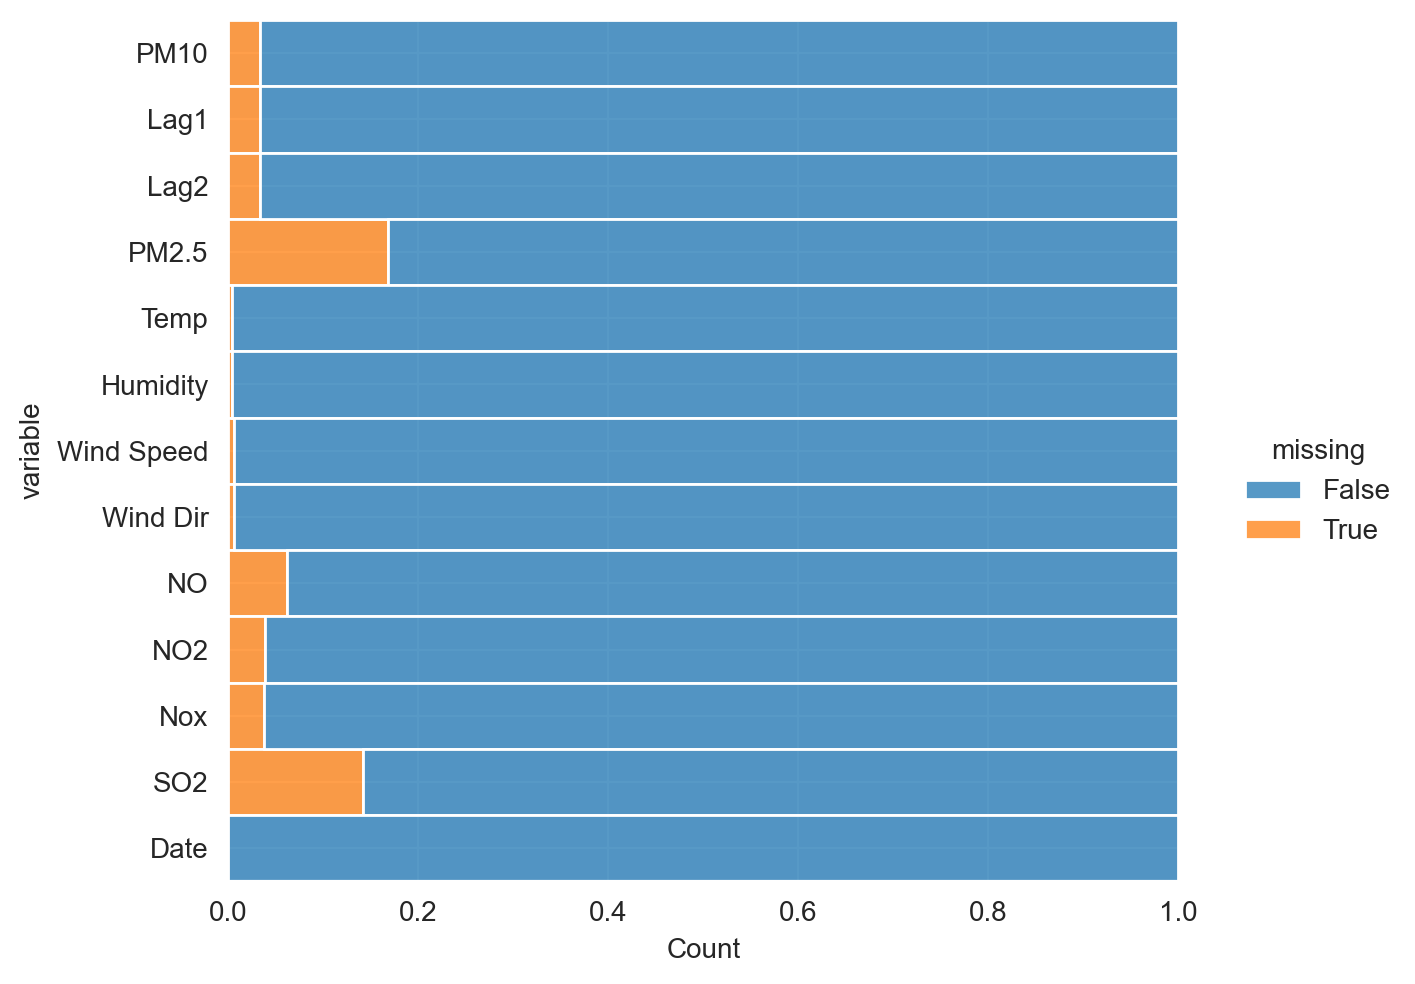

In [134]:
plt.figure(figsize=(10,6))
sns.displot(
    data=df.isna().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    aspect=1.25
)
plt.savefig("visualizing_missing_data_with_barplot_Seaborn_distplot.png", dpi=100)


In [135]:
# Moving Average:
n = 24
df['Temp'] = df['Temp'].fillna(df['Temp'].rolling(window=n, min_periods=1).mean().round())
df['Humidity'] = df['Humidity'].fillna(df['Humidity'].rolling(window=n, min_periods=1).mean().round())

 # Set 'Date' column as the index
if not df.index.name == 'Date':
    df.set_index('Date', inplace=True)
    
df['SO2'] = df['SO2'].fillna(df['SO2'].interpolate(method='time'))
df['NO2'] = df['NO2'].fillna(df['NO2'].interpolate(method='time'))
df['NO'] = df['NO'].fillna(df['NO'].interpolate(method='time'))
df['Nox'] = df['Nox'].fillna(df['Nox'].interpolate(method='time'))
df['Wind Dir'] = df['Wind Dir'].fillna(df['Wind Dir'].interpolate(method='time'))
df['Wind Speed'] = df['Wind Speed'].fillna(df['Wind Speed'].interpolate(method='time'))
df['PM10'] = df['PM10'].fillna(df['PM10'].interpolate(method='time'))
df['PM2.5'] = df['PM2.5'].fillna(df['PM10'].interpolate(method='time'))

df.reset_index(inplace=True)

df

,Date,PM10,Lag1,Lag2,PM2.5,Temp,Humidity,Wind Speed,Wind Dir,NO,NO2,Nox,SO2
0,2018-12-01 00:00:00,15.8,10.2,18.6,6.5,18.0,76.1,5.4,52.0,0.2,0.8,1.0,1.70
1,2018-12-01 01:00:00,18.1,9.1,21.4,25.6,18.0,79.1,4.8,60.0,0.1,0.6,0.5,1.55
2,2018-12-01 02:00:00,15.9,8.6,17.8,1.7,18.0,76.4,4.7,61.0,0.0,0.5,0.5,1.40
3,2018-12-01 03:00:00,16.1,9.9,17.5,1.7,18.0,75.1,5.2,53.0,0.0,0.3,0.2,1.60
4,2018-12-01 04:00:00,18.5,7.1,21.7,18.5,18.0,79.2,5.0,56.0,0.2,0.3,0.4,1.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...
34499,2022-11-15 19:00:00,1.0,21.4,21.6,0.4,17.0,79.0,2.4,217.0,41.5,31.2,72.6,0.60
34500,2022-11-15 20:00:00,8.5,16.2,10.6,0.6,17.0,80.0,2.4,217.0,41.5,31.2,72.6,0.90
34501,2022-11-15 21:00:00,0.0,13.5,19.9,2.6,17.0,80.0,2.4,217.0,41.5,31.2,72.6,0.80
34502,2022-11-15 22:00:00,3.0,16.7,9.8,4.6,17.0,81.0,2.4,217.0,41.5,31.2,72.6,0.80


<Figure size 1000x600 with 0 Axes>

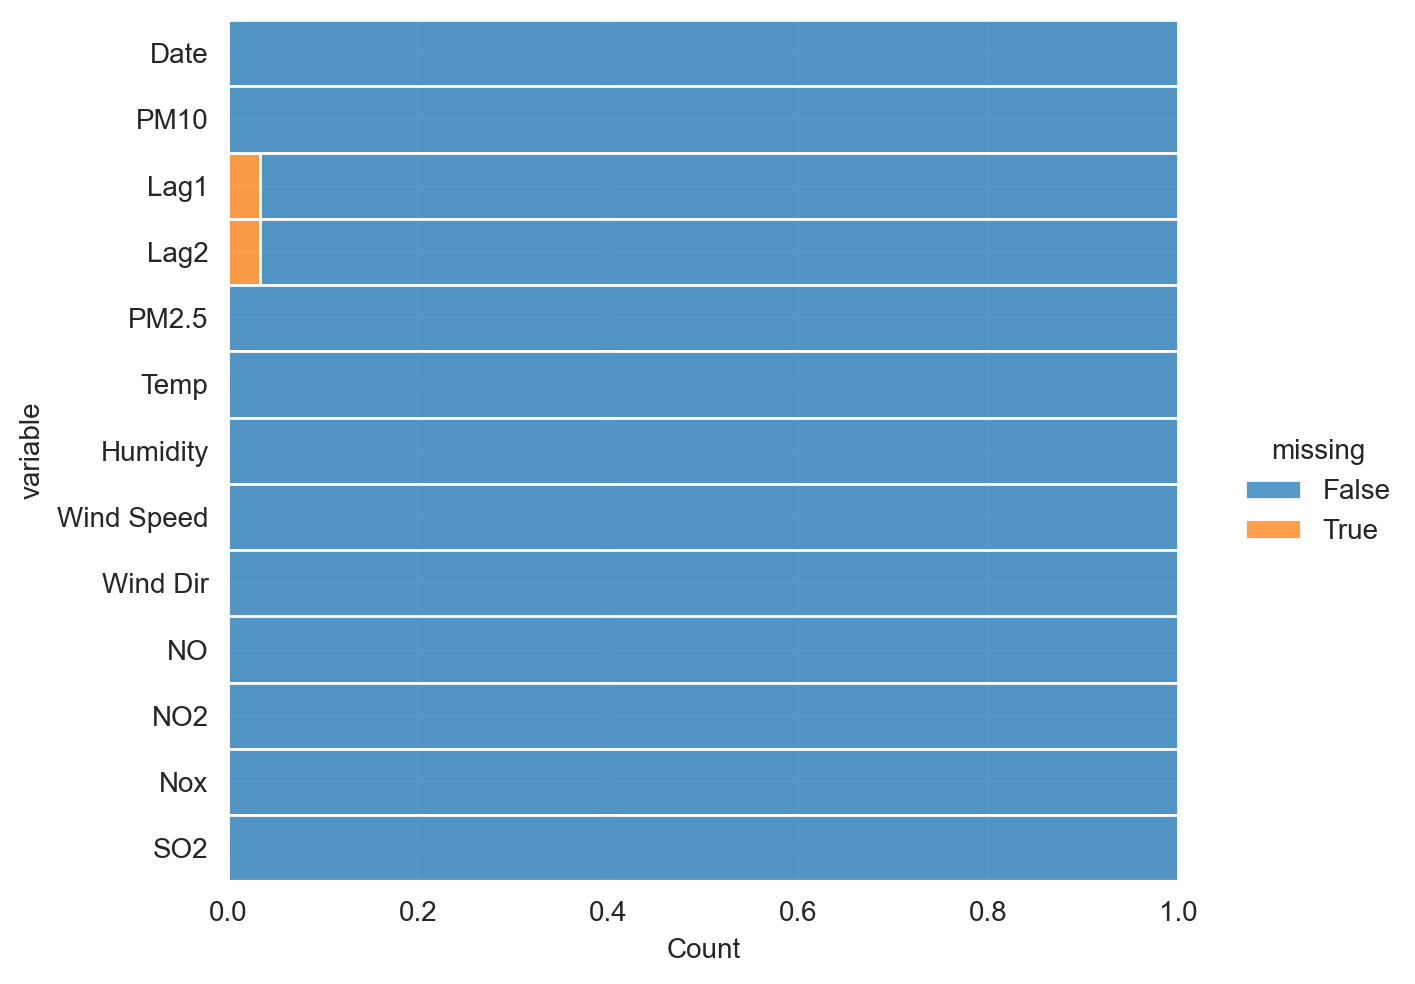

In [136]:
plt.figure(figsize=(10,6))
sns.displot(
    data=df.isna().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    aspect=1.25
)
plt.savefig("visualizing_missing_data_with_barplot_Seaborn_distplot.png", dpi=100)

In [137]:
# Compute lag column (1 period shift)
df['lag1'] = df['PM10'].shift(24) #24 hours before

# Compute lag2 column (2 periods shift)
df['lag2'] = df['PM10'].shift(48) #48 hours before

In [138]:
df = df[df['Date'] >= "2018-12-01 00:00:00"]
df.reset_index(inplace=True)

df

,index,Date,PM10,Lag1,Lag2,PM2.5,Temp,Humidity,Wind Speed,Wind Dir,NO,NO2,Nox,SO2,lag1,lag2
0,0,2018-12-01 00:00:00,15.8,10.2,18.6,6.5,18.0,76.1,5.4,52.0,0.2,0.8,1.0,1.70,NaN,NaN
1,1,2018-12-01 01:00:00,18.1,9.1,21.4,25.6,18.0,79.1,4.8,60.0,0.1,0.6,0.5,1.55,NaN,NaN
2,2,2018-12-01 02:00:00,15.9,8.6,17.8,1.7,18.0,76.4,4.7,61.0,0.0,0.5,0.5,1.40,NaN,NaN
3,3,2018-12-01 03:00:00,16.1,9.9,17.5,1.7,18.0,75.1,5.2,53.0,0.0,0.3,0.2,1.60,NaN,NaN
4,4,2018-12-01 04:00:00,18.5,7.1,21.7,18.5,18.0,79.2,5.0,56.0,0.2,0.3,0.4,1.50,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34499,34499,2022-11-15 19:00:00,1.0,21.4,21.6,0.4,17.0,79.0,2.4,217.0,41.5,31.2,72.6,0.60,21.4,21.6
34500,34500,2022-11-15 20:00:00,8.5,16.2,10.6,0.6,17.0,80.0,2.4,217.0,41.5,31.2,72.6,0.90,16.2,10.6
34501,34501,2022-11-15 21:00:00,0.0,13.5,19.9,2.6,17.0,80.0,2.4,217.0,41.5,31.2,72.6,0.80,13.5,19.9
34502,34502,2022-11-15 22:00:00,3.0,16.7,9.8,4.6,17.0,81.0,2.4,217.0,41.5,31.2,72.6,0.80,16.7,9.8


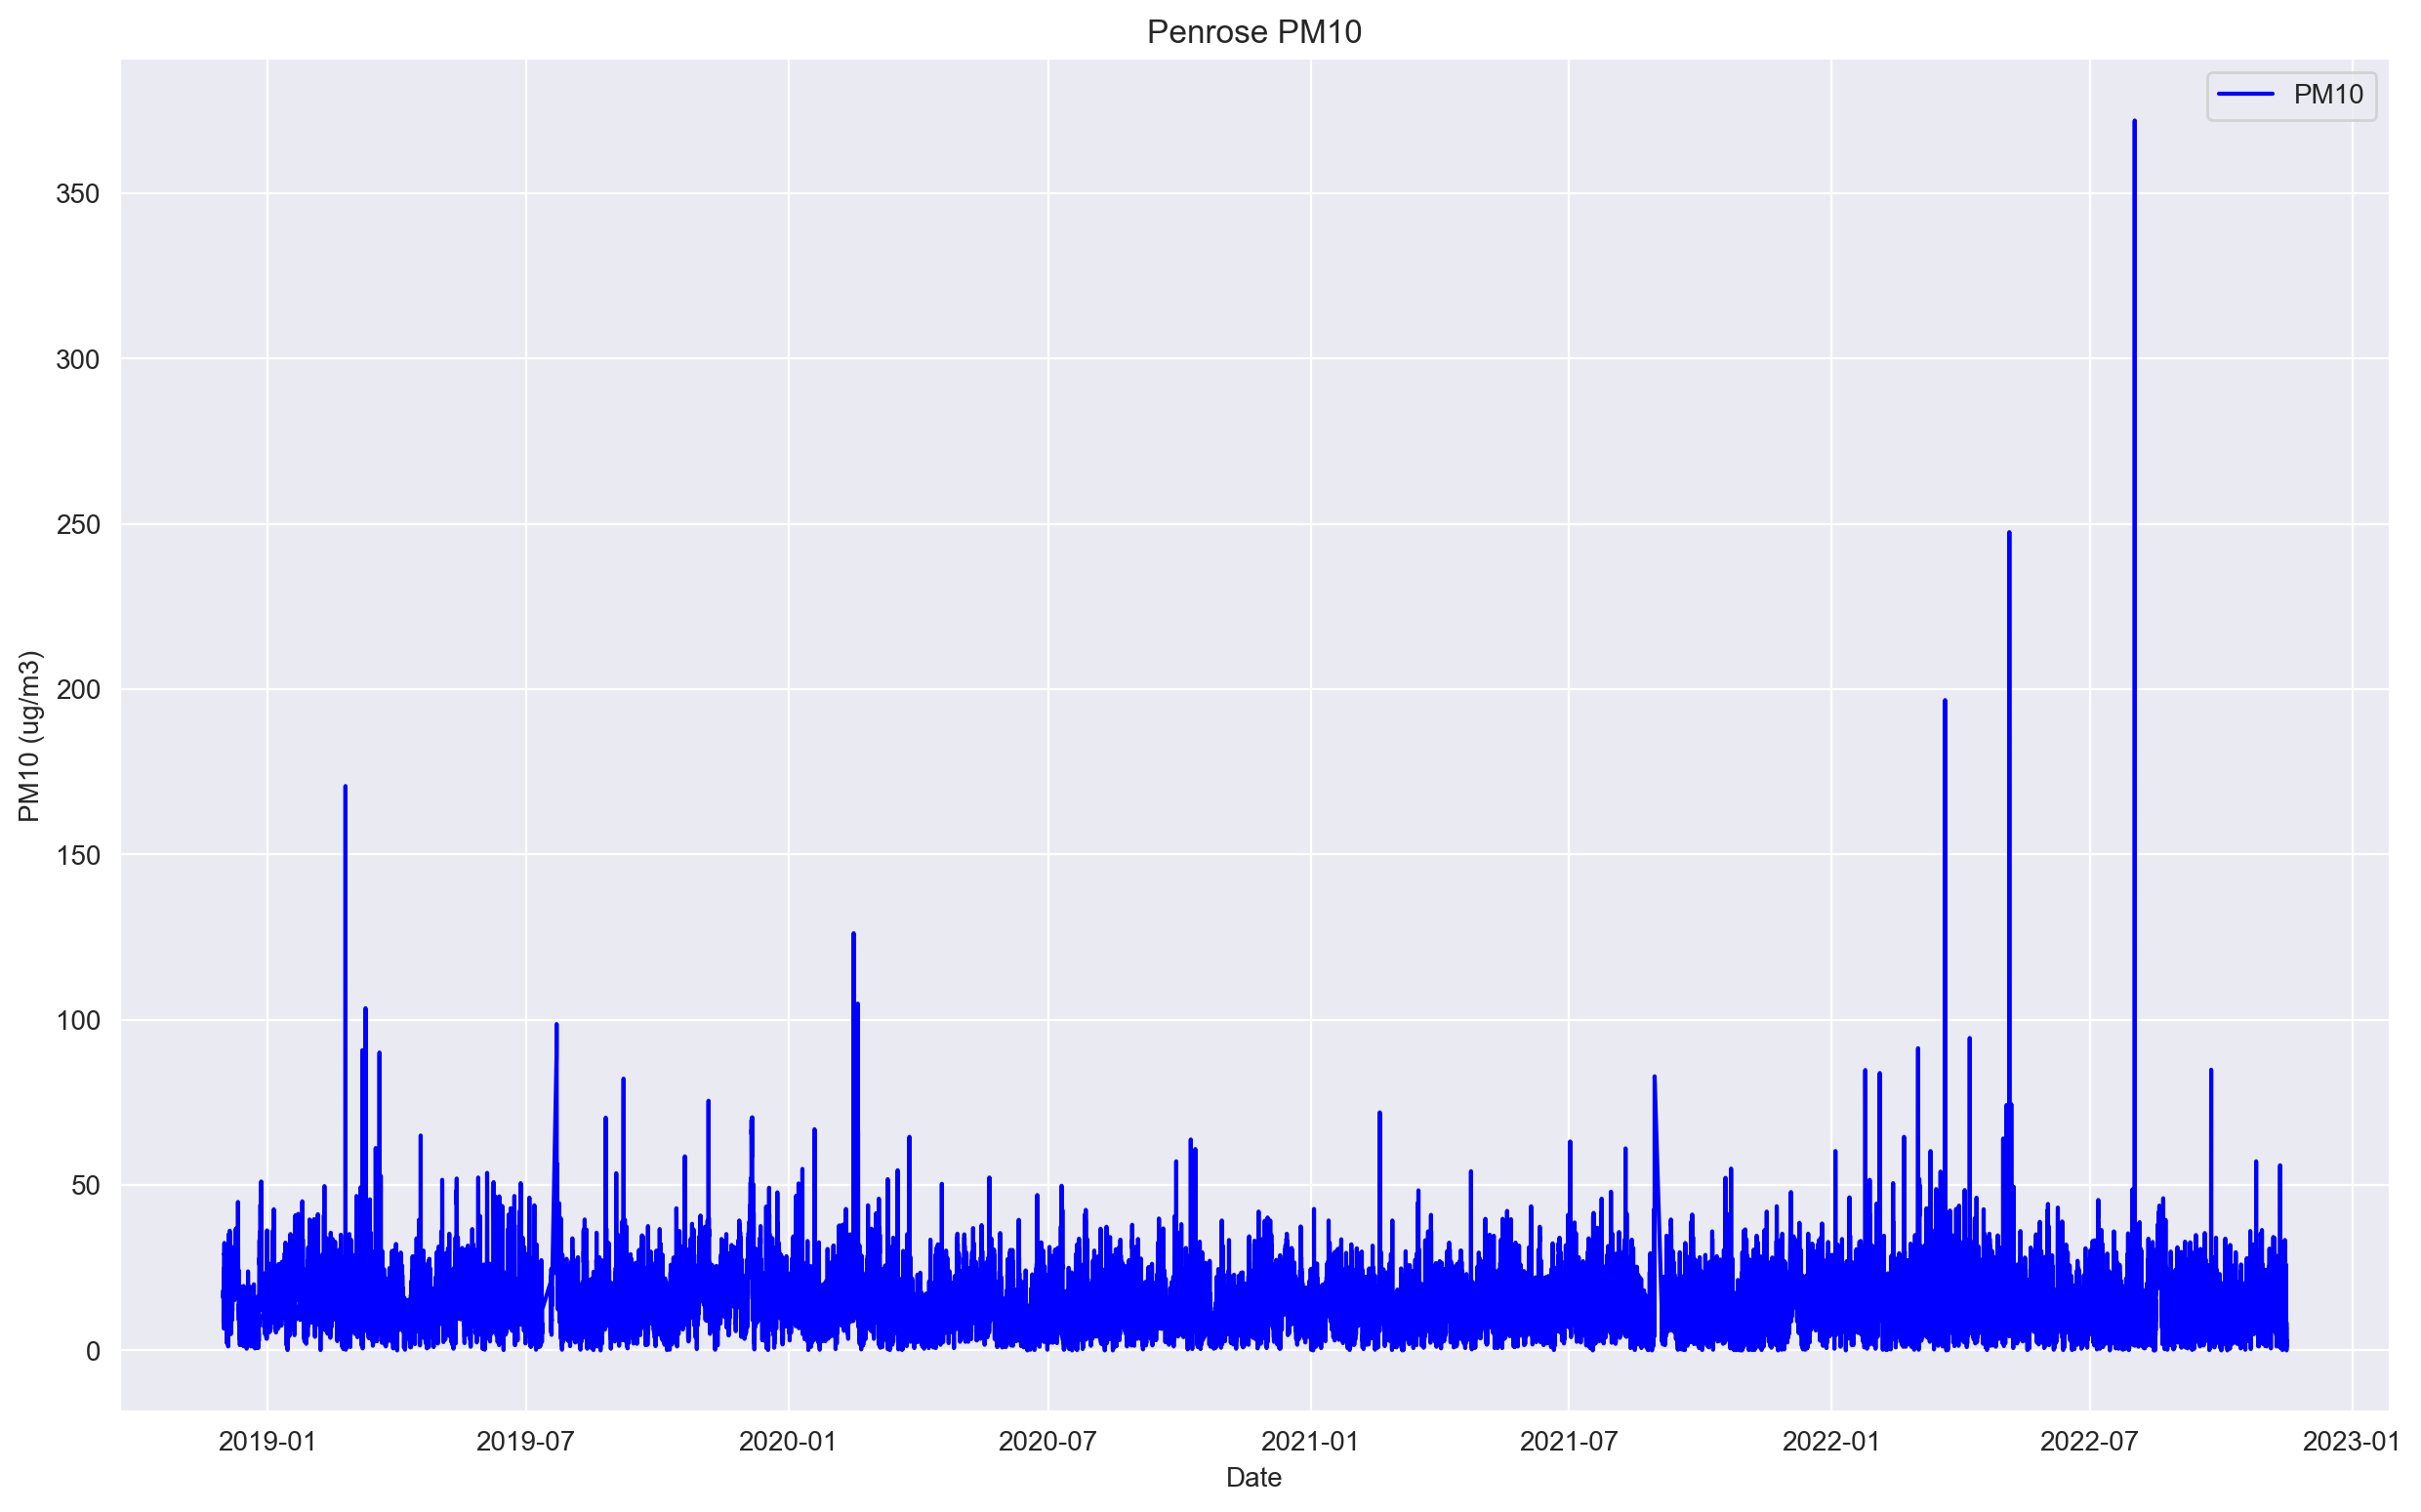

In [139]:
# Visualising the results
fig, ax = plt.subplots()

ax.plot(df["Date"], df["PM10"], color='blue', label='PM10')

ax.set_title('Penrose PM10')
ax.set_xlabel('Date')
ax.set_ylabel('PM10 (ug/m3)')
ax.legend()

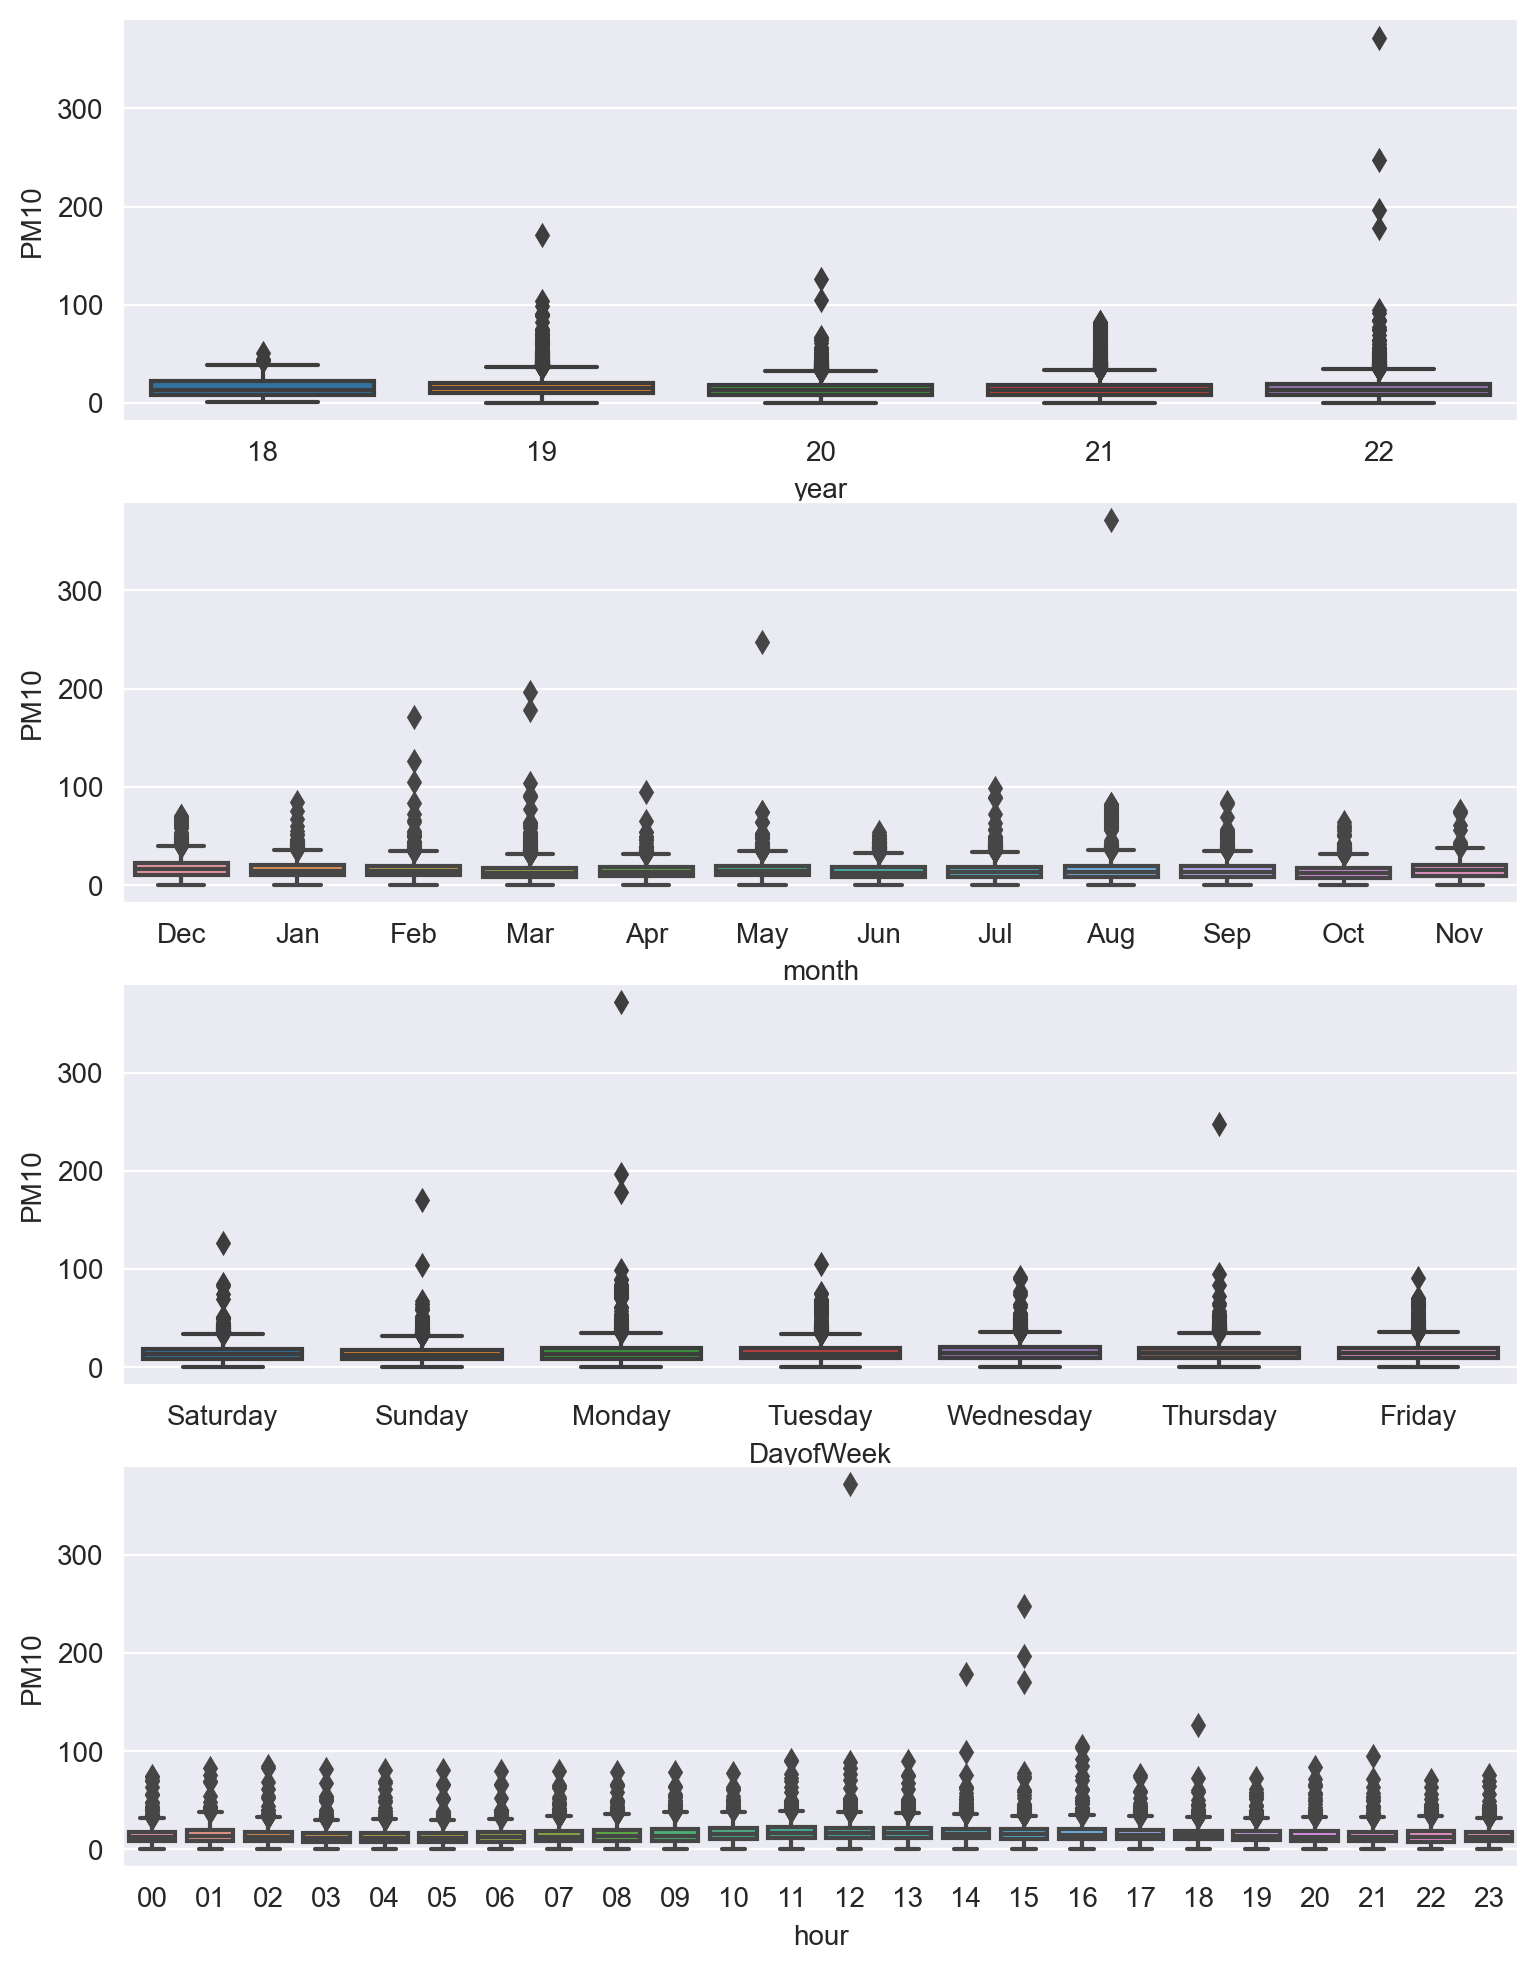

In [140]:
"""
(Do a proper EDA (Exploratory data analysis )) !!
"""

df['year'] = pd.to_datetime(df['Date']).dt.strftime('%y')
df['month'] = pd.to_datetime(df['Date']).dt.strftime('%b')
df['DayofWeek'] = pd.to_datetime(df['Date']).dt.strftime('%A')
df['hour'] = pd.to_datetime(df['Date']).dt.strftime('%H')

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1)
fig.set_figheight(12)
fig.set_figwidth(9)

sns.boxplot(x='year', y='PM10', data=df, ax=ax1)
sns.boxplot(x='month', y='PM10', data=df, ax=ax2)
sns.boxplot(x='DayofWeek', y='PM10', data=df, ax=ax3)
sns.boxplot(x='hour', y='PM10', data=df, ax=ax4) 

plt.show()

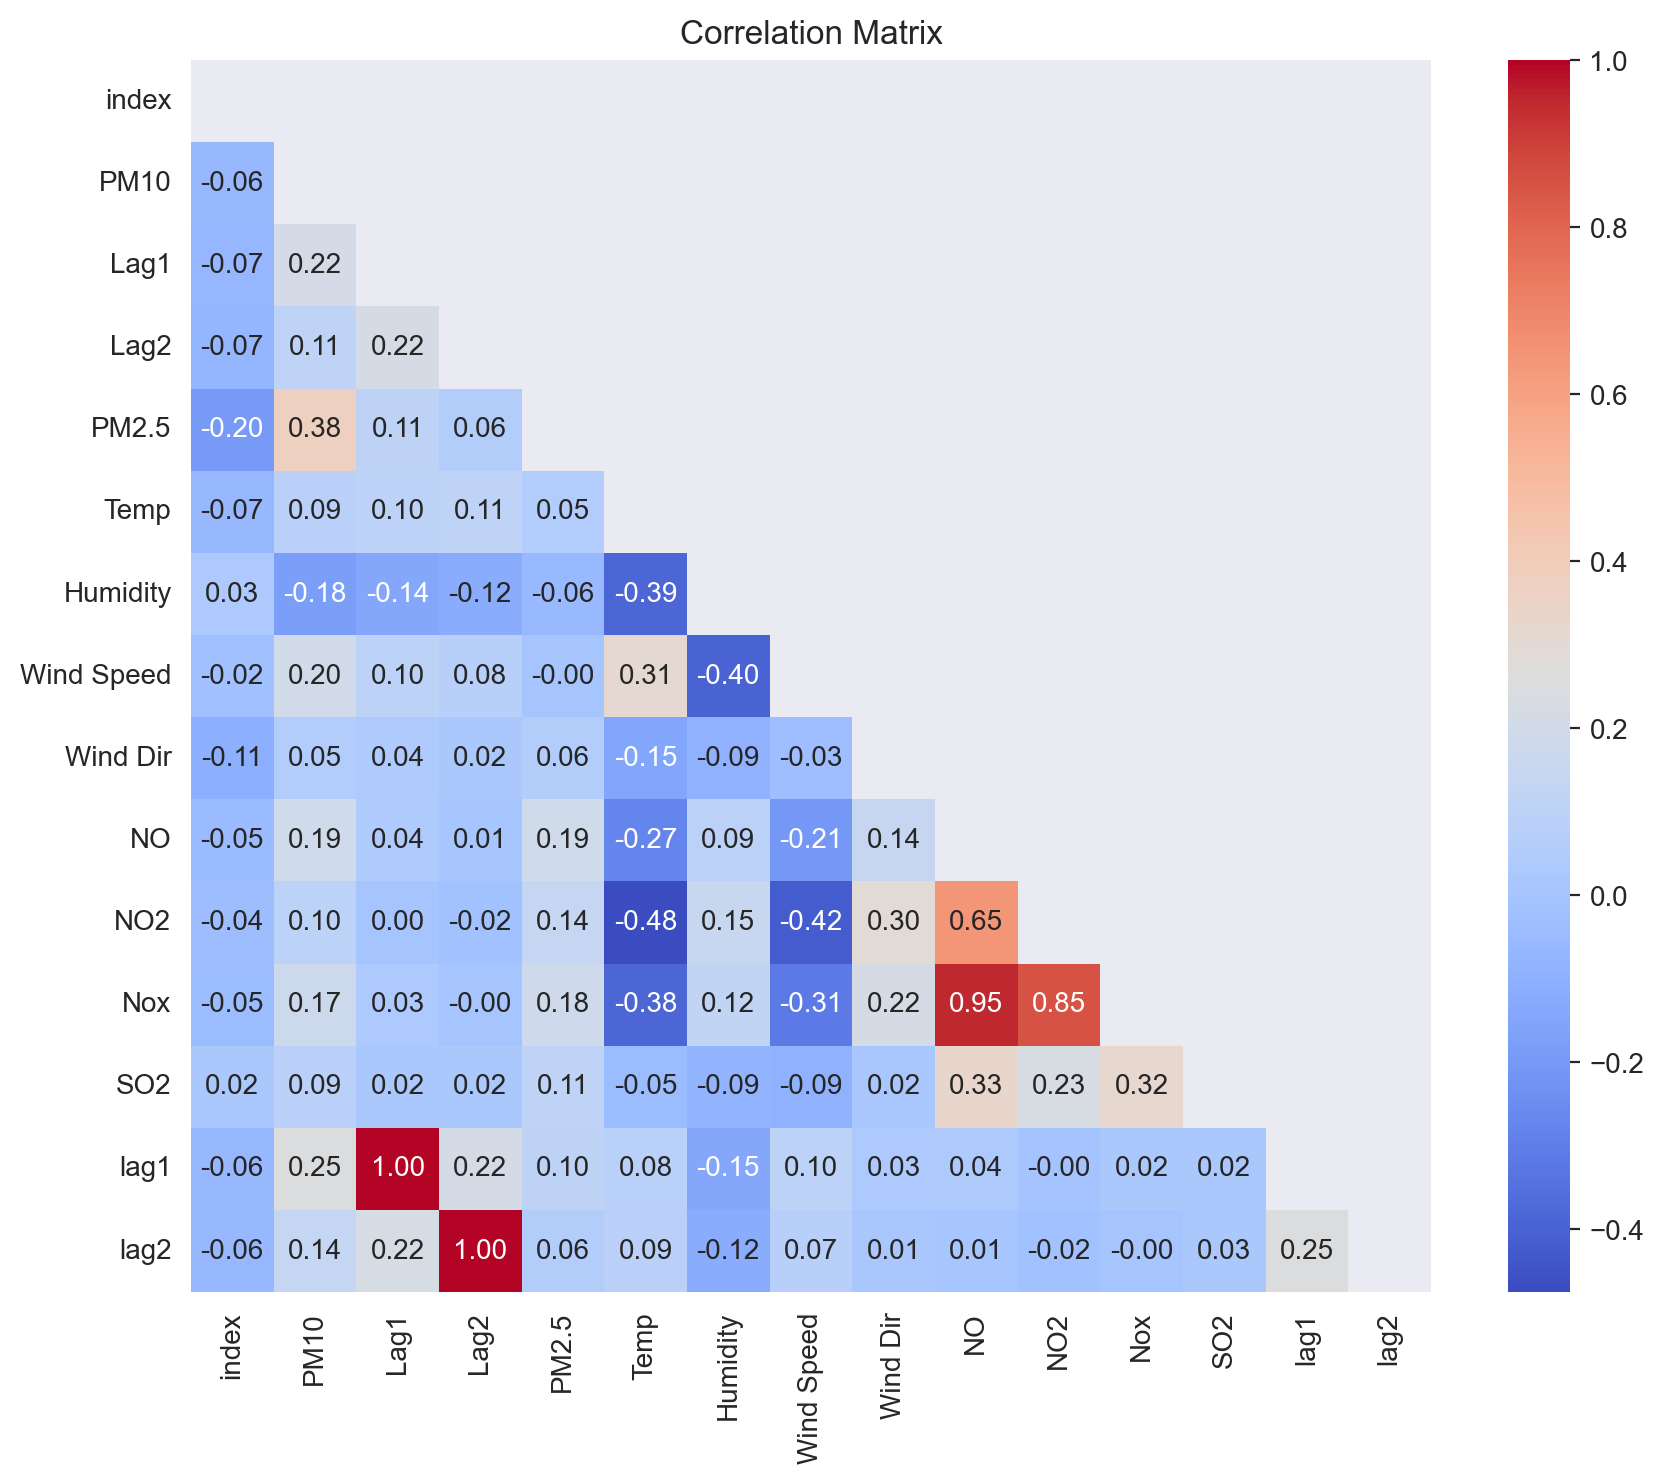

In [141]:
# Compute the correlation matrix
corr_matrix = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(10, 8))

# Create the correlation heatmap
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, ax=ax)

# Set plot title
plt.title("Correlation Matrix")

# Show the plot
plt.show()


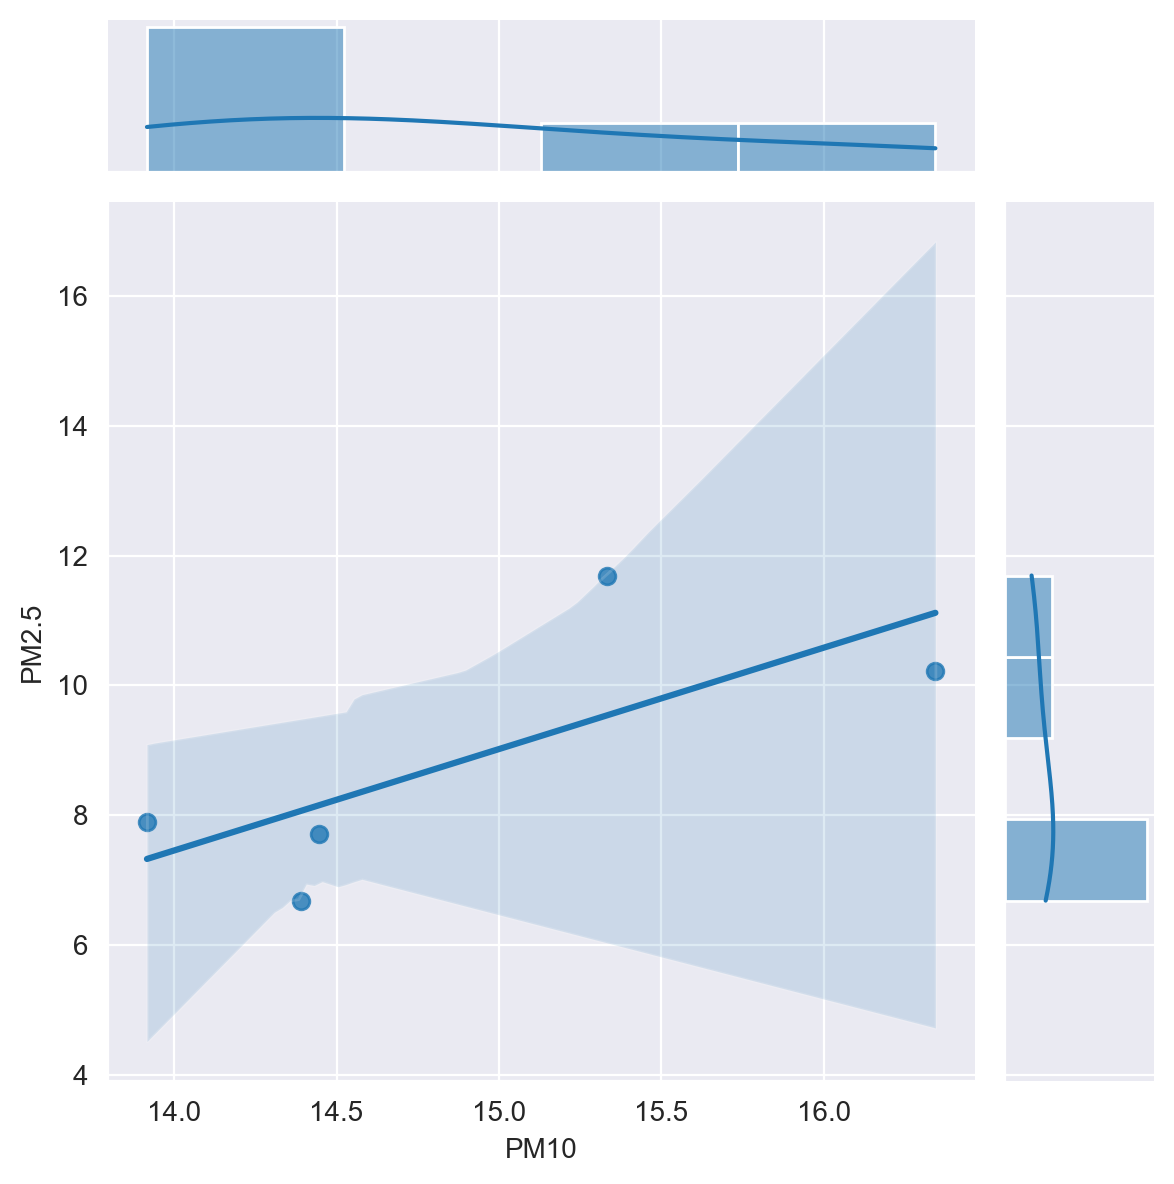

In [142]:
relation = sns.jointplot(x='PM10', y='PM2.5', data=df.set_index('Date').resample('Y').mean(), kind='reg')

In [154]:
import pandas as pd
import numpy as np
import statsmodels.api as sm


# Identify numeric columns
numeric_columns = df.select_dtypes(include=np.number).columns

# Replace negative values with NaN
df[numeric_columns] = df[numeric_columns].mask(df[numeric_columns] < 0)

# Replace NaN values with means
df.fillna(df.mean(), inplace=True)

# Select the variables for regression
variables = ['Lag1', 'Lag2', 'Temp', 'Humidity', 'Wind Speed', 'Wind Dir', 'NO2', 'SO2']
X = df[variables]
y = df['PM10']

# Add a constant term to the predictor variables
X = sm.add_constant(X)

# Split the data into training and testing sets
train_size = int(0.8 * len(df))  # 80% for training
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Fit the regression model
model = sm.OLS(y_train, X_train)
results = model.fit()

# Print the regression results
print(results.summary())

# Print the evaluation metrics
print("\nEvaluation Metrics:")
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("Correlation Coefficient (R2):", r2)



                            OLS Regression Results                            
Dep. Variable:                   PM10   R-squared:                       0.146
Model:                            OLS   Adj. R-squared:                  0.146
Method:                 Least Squares   F-statistic:                     590.6
Date:                Wed, 14 Jun 2023   Prob (F-statistic):               0.00
Time:                        18:14:03   Log-Likelihood:                -96365.
No. Observations:               27603   AIC:                         1.927e+05
Df Residuals:                   27594   BIC:                         1.928e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.0781      0.571      8.897      0.0

In [53]:
# Drop 'lag1' and 'lag2' columns from the DataFrame
df_dropped = df.drop(['lag1', 'lag2'], axis=1)

# Compute the correlation matrix
correlation_matrix = df_dropped.corr()

# Create a styled table
correlation_table = correlation_matrix.style.background_gradient(cmap='coolwarm')

# Display the correlation table
correlation_table


,index,PM10,Lag1,Lag2,PM2.5,Temp,Humidity,Wind Speed,Wind Dir,NO,NO2,Nox,SO2
index,1.000000,-0.062371,-0.062307,-0.062243,-0.197858,-0.065951,0.030067,-0.022304,-0.106625,-0.051279,-0.040398,-0.048157,0.023019
PM10,-0.062371,1.000000,0.628814,0.535216,0.375045,0.087489,-0.178522,0.196384,0.052162,0.189880,0.099566,0.170263,0.085646
Lag1,-0.062307,0.628814,1.000000,0.628796,0.288702,0.090903,-0.183676,0.196693,0.048708,0.125278,0.053561,0.107319,0.060111
Lag2,-0.062243,0.535216,0.628796,1.000000,0.228864,0.091217,-0.182920,0.191262,0.042974,0.070888,0.018539,0.055667,0.038619
PM2.5,-0.197858,0.375045,0.288702,0.228864,1.000000,0.054058,-0.057354,-0.001581,0.056328,0.190166,0.136054,0.182286,0.108886
Temp,-0.065951,0.087489,0.090903,0.091217,0.054058,1.000000,-0.387548,0.309058,-0.151919,-0.274464,-0.475419,-0.383882,-0.045482
Humidity,0.030067,-0.178522,-0.183676,-0.182920,-0.057354,-0.387548,1.000000,-0.395647,-0.090870,0.089698,0.147422,0.121405,-0.087036
Wind Speed,-0.022304,0.196384,0.196693,0.191262,-0.001581,0.309058,-0.395647,1.000000,-0.034275,-0.209650,-0.422752,-0.314373,-0.089425
Wind Dir,-0.106625,0.052162,0.048708,0.042974,0.056328,-0.151919,-0.090870,-0.034275,1.000000,0.143172,0.295542,0.218229,0.017629
NO,-0.051279,0.189880,0.125278,0.070888,0.190166,-0.274464,0.089698,-0.209650,0.143172,1.000000,0.647514,0.950426,0.327504


In [148]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.stats.api as sms
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
from scipy import stats
%matplotlib inline
%matplotlib inline
%config InlineBackend.figure_format ='retina'

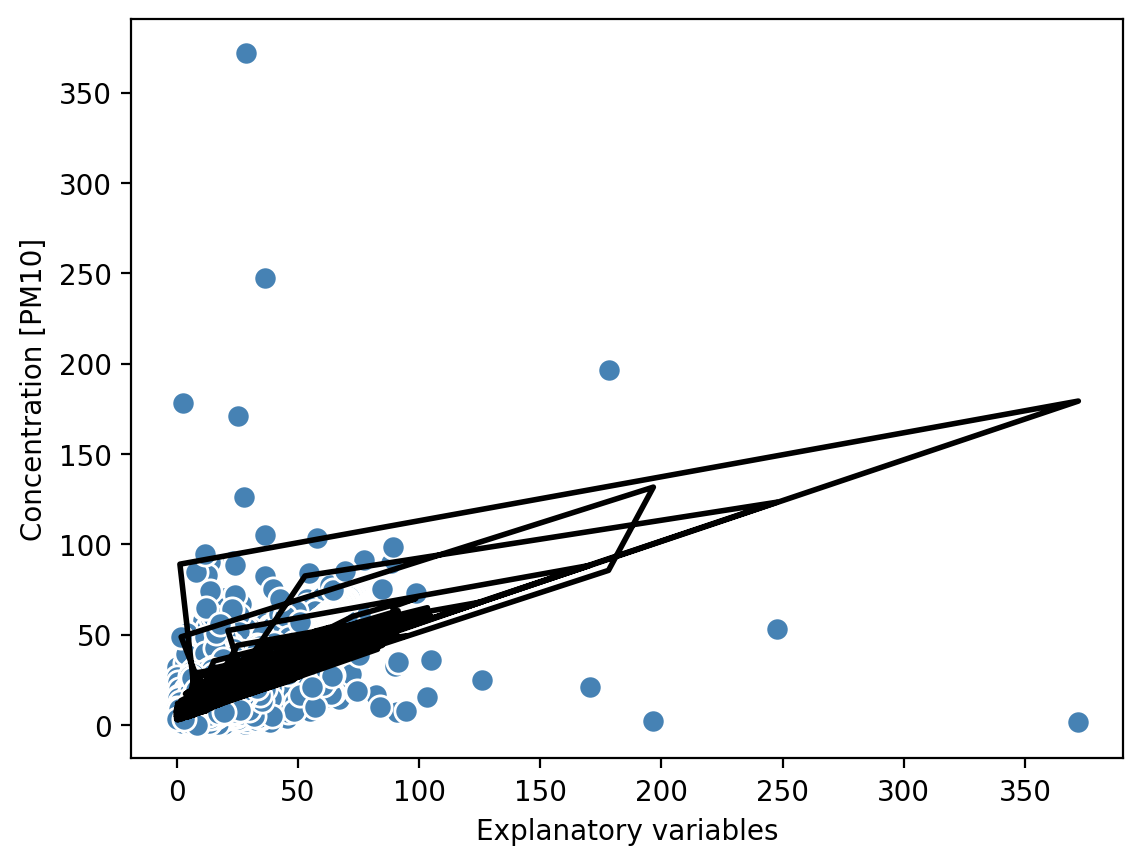

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

x = df[['Lag1', 'Lag2','Temp','Humidity','Wind Speed', 'Wind Dir','NO','NO2','SO2']].values
y = df['PM10'].values

# Applying Sklearn linear regression model
slr = LinearRegression()
slr.fit(x, y)

def lin_reg_plot(X, y, model):
    plt.scatter(X[:, 0], y, c='steelblue', edgecolor='white', s=70)  # Plotting the first feature against y
    plt.plot(X[:, 0], model.predict(X), color='black', lw=2)  # Plotting the regression line
    plt.xlabel('Explanatory variables')
    plt.ylabel('Concentration [PM10]')
    plt.show()

lin_reg_plot(x, y, slr)


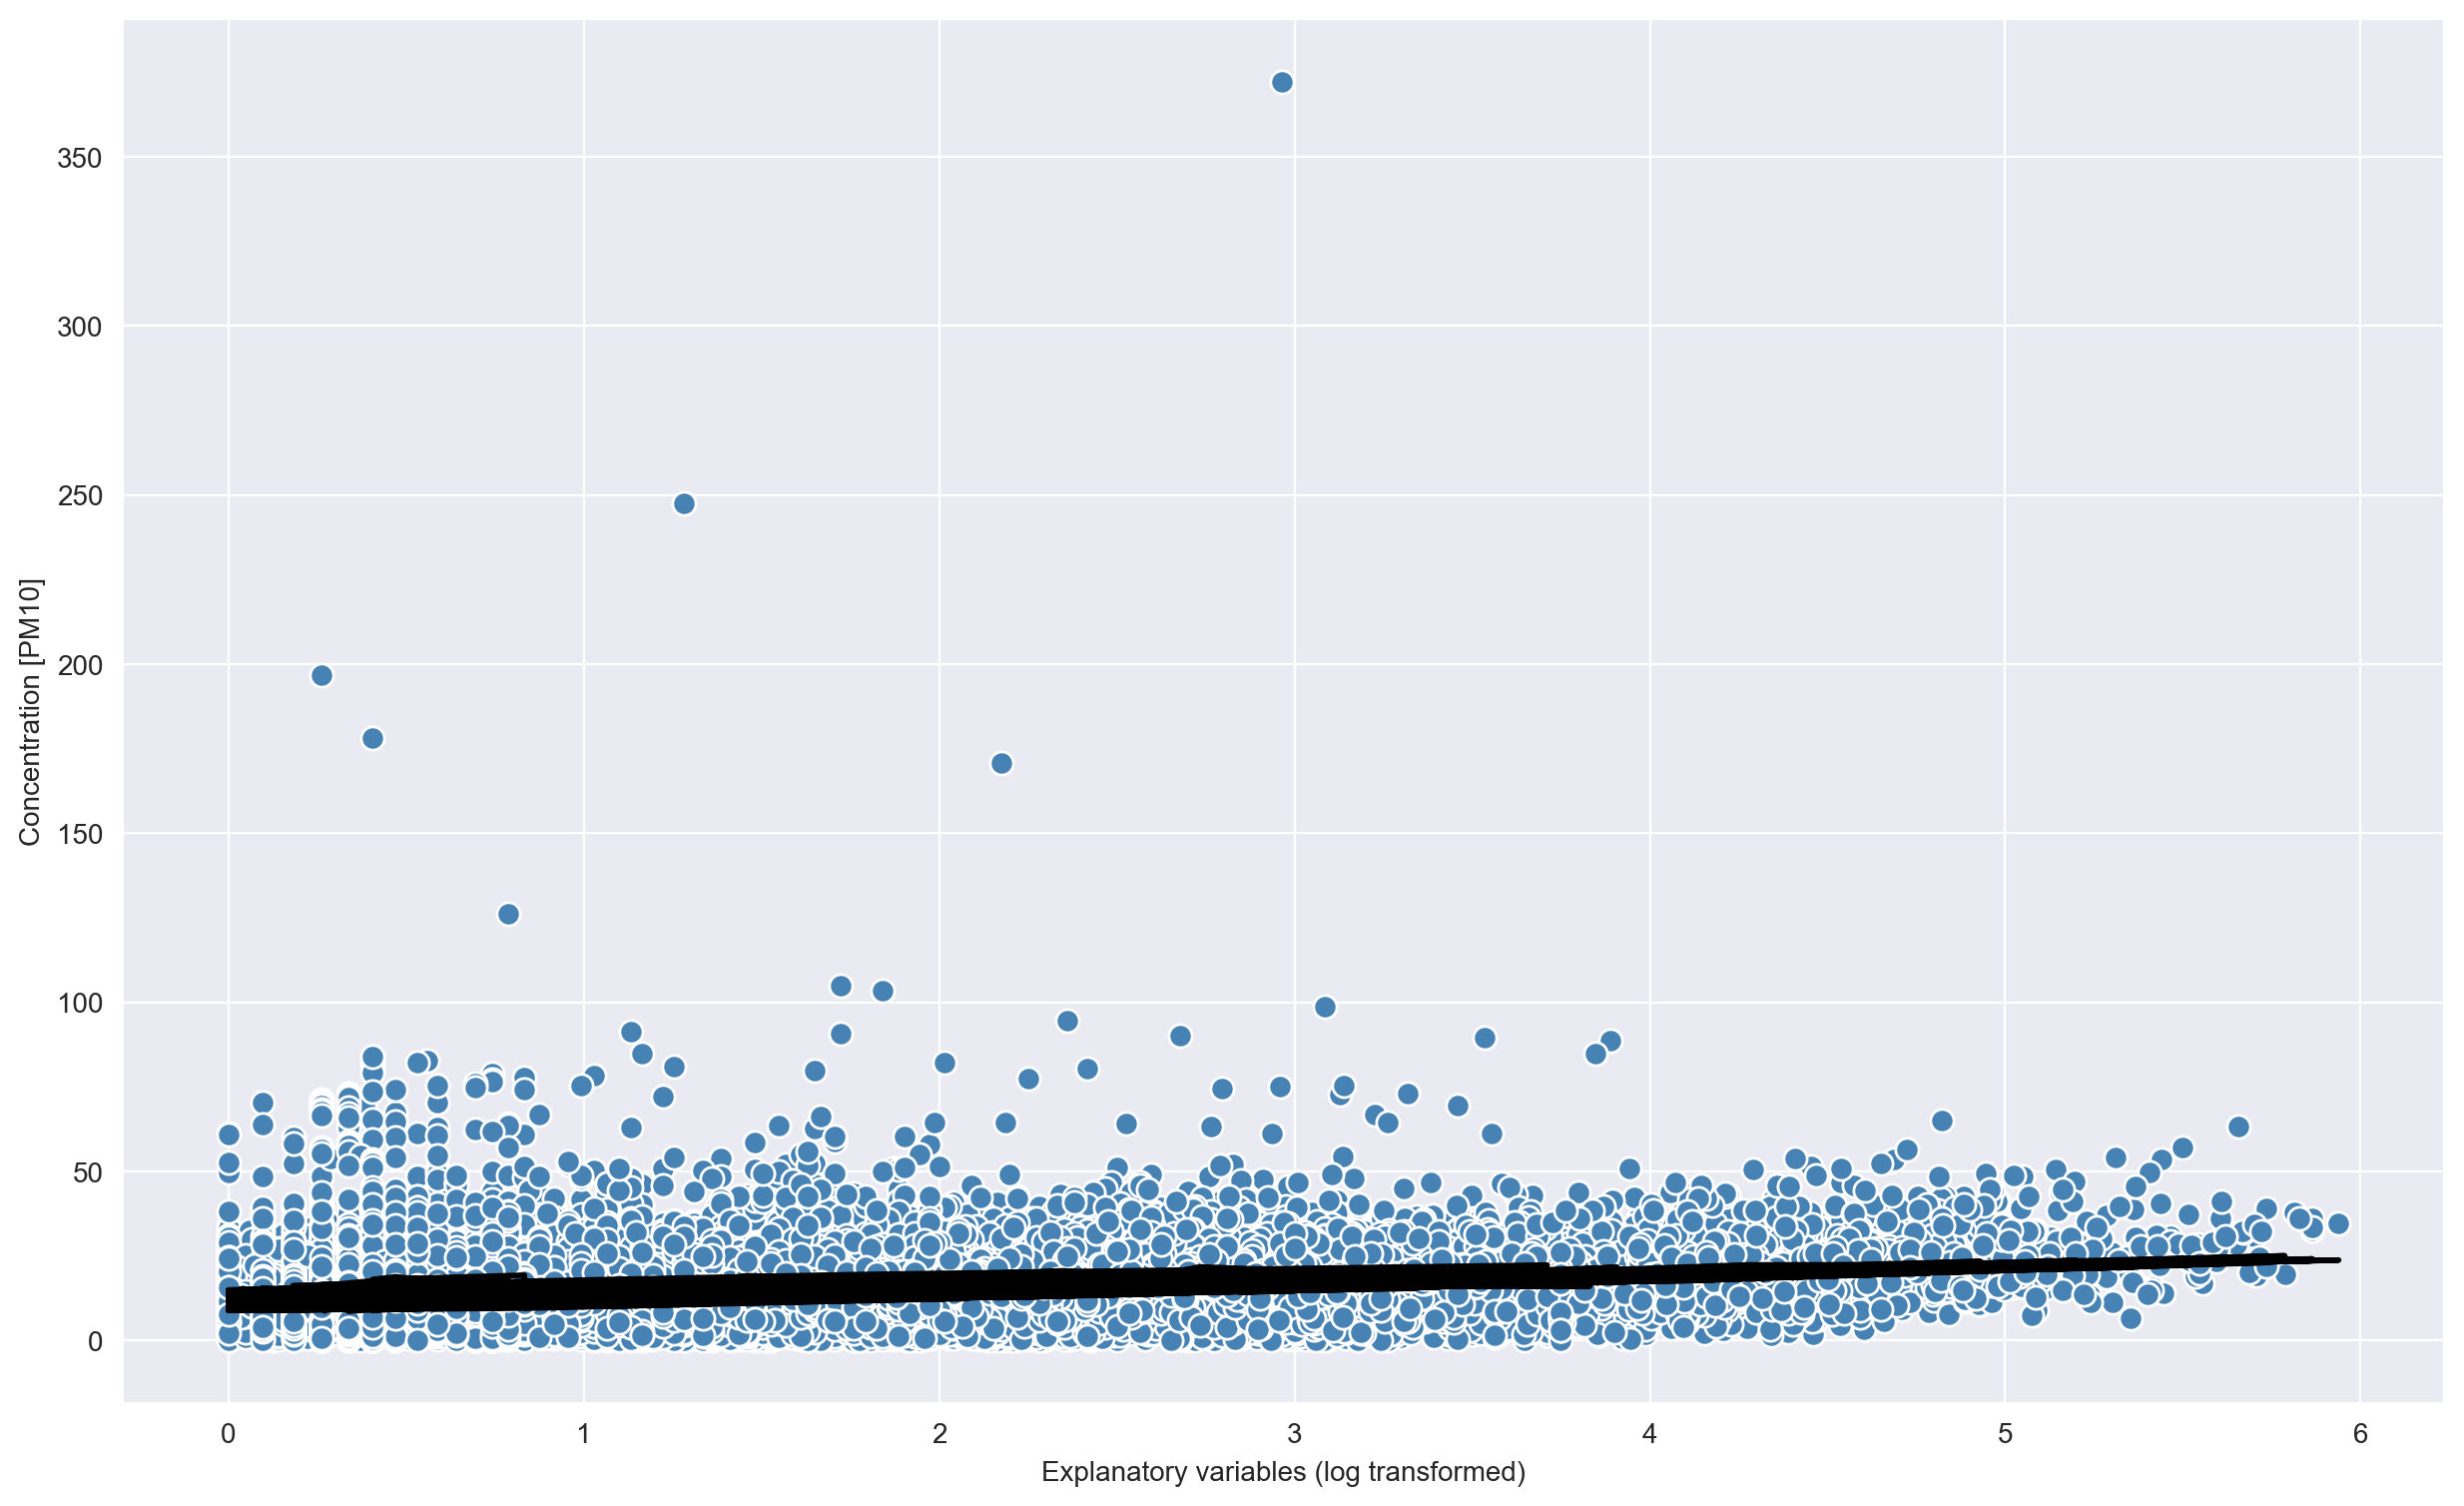

In [149]:
import numpy as np
import matplotlib.pyplot as plt

# Apply logarithmic transformation to the features
log_x = np.log1p(x)

# Applying Sklearn linear regression model
slr = LinearRegression()
slr.fit(log_x, y)

def lin_reg_plot(X, y, model):
    plt.scatter(X[:, 0], y, c='steelblue', edgecolor='white', s=70)  # Plotting the first feature against y
    plt.plot(X[:, 0], model.predict(X), color='black', lw=2)  # Plotting the regression line
    plt.xlabel('Explanatory variables (log transformed)')
    plt.ylabel('Concentration [PM10]')
    plt.show()

lin_reg_plot(log_x, y, slr)


The varying thickness of the regression line could be an indication of heteroscedasticity in the data, which means that the variance of the residuals (the differences between the actual values and the predicted values) is not constant across the range of the independent variable.
This could be because of the presence of outliers or the violation of certain assumptions of the linear regression model. One common assumption is that the error terms should have constant variance (homoscedasticity).

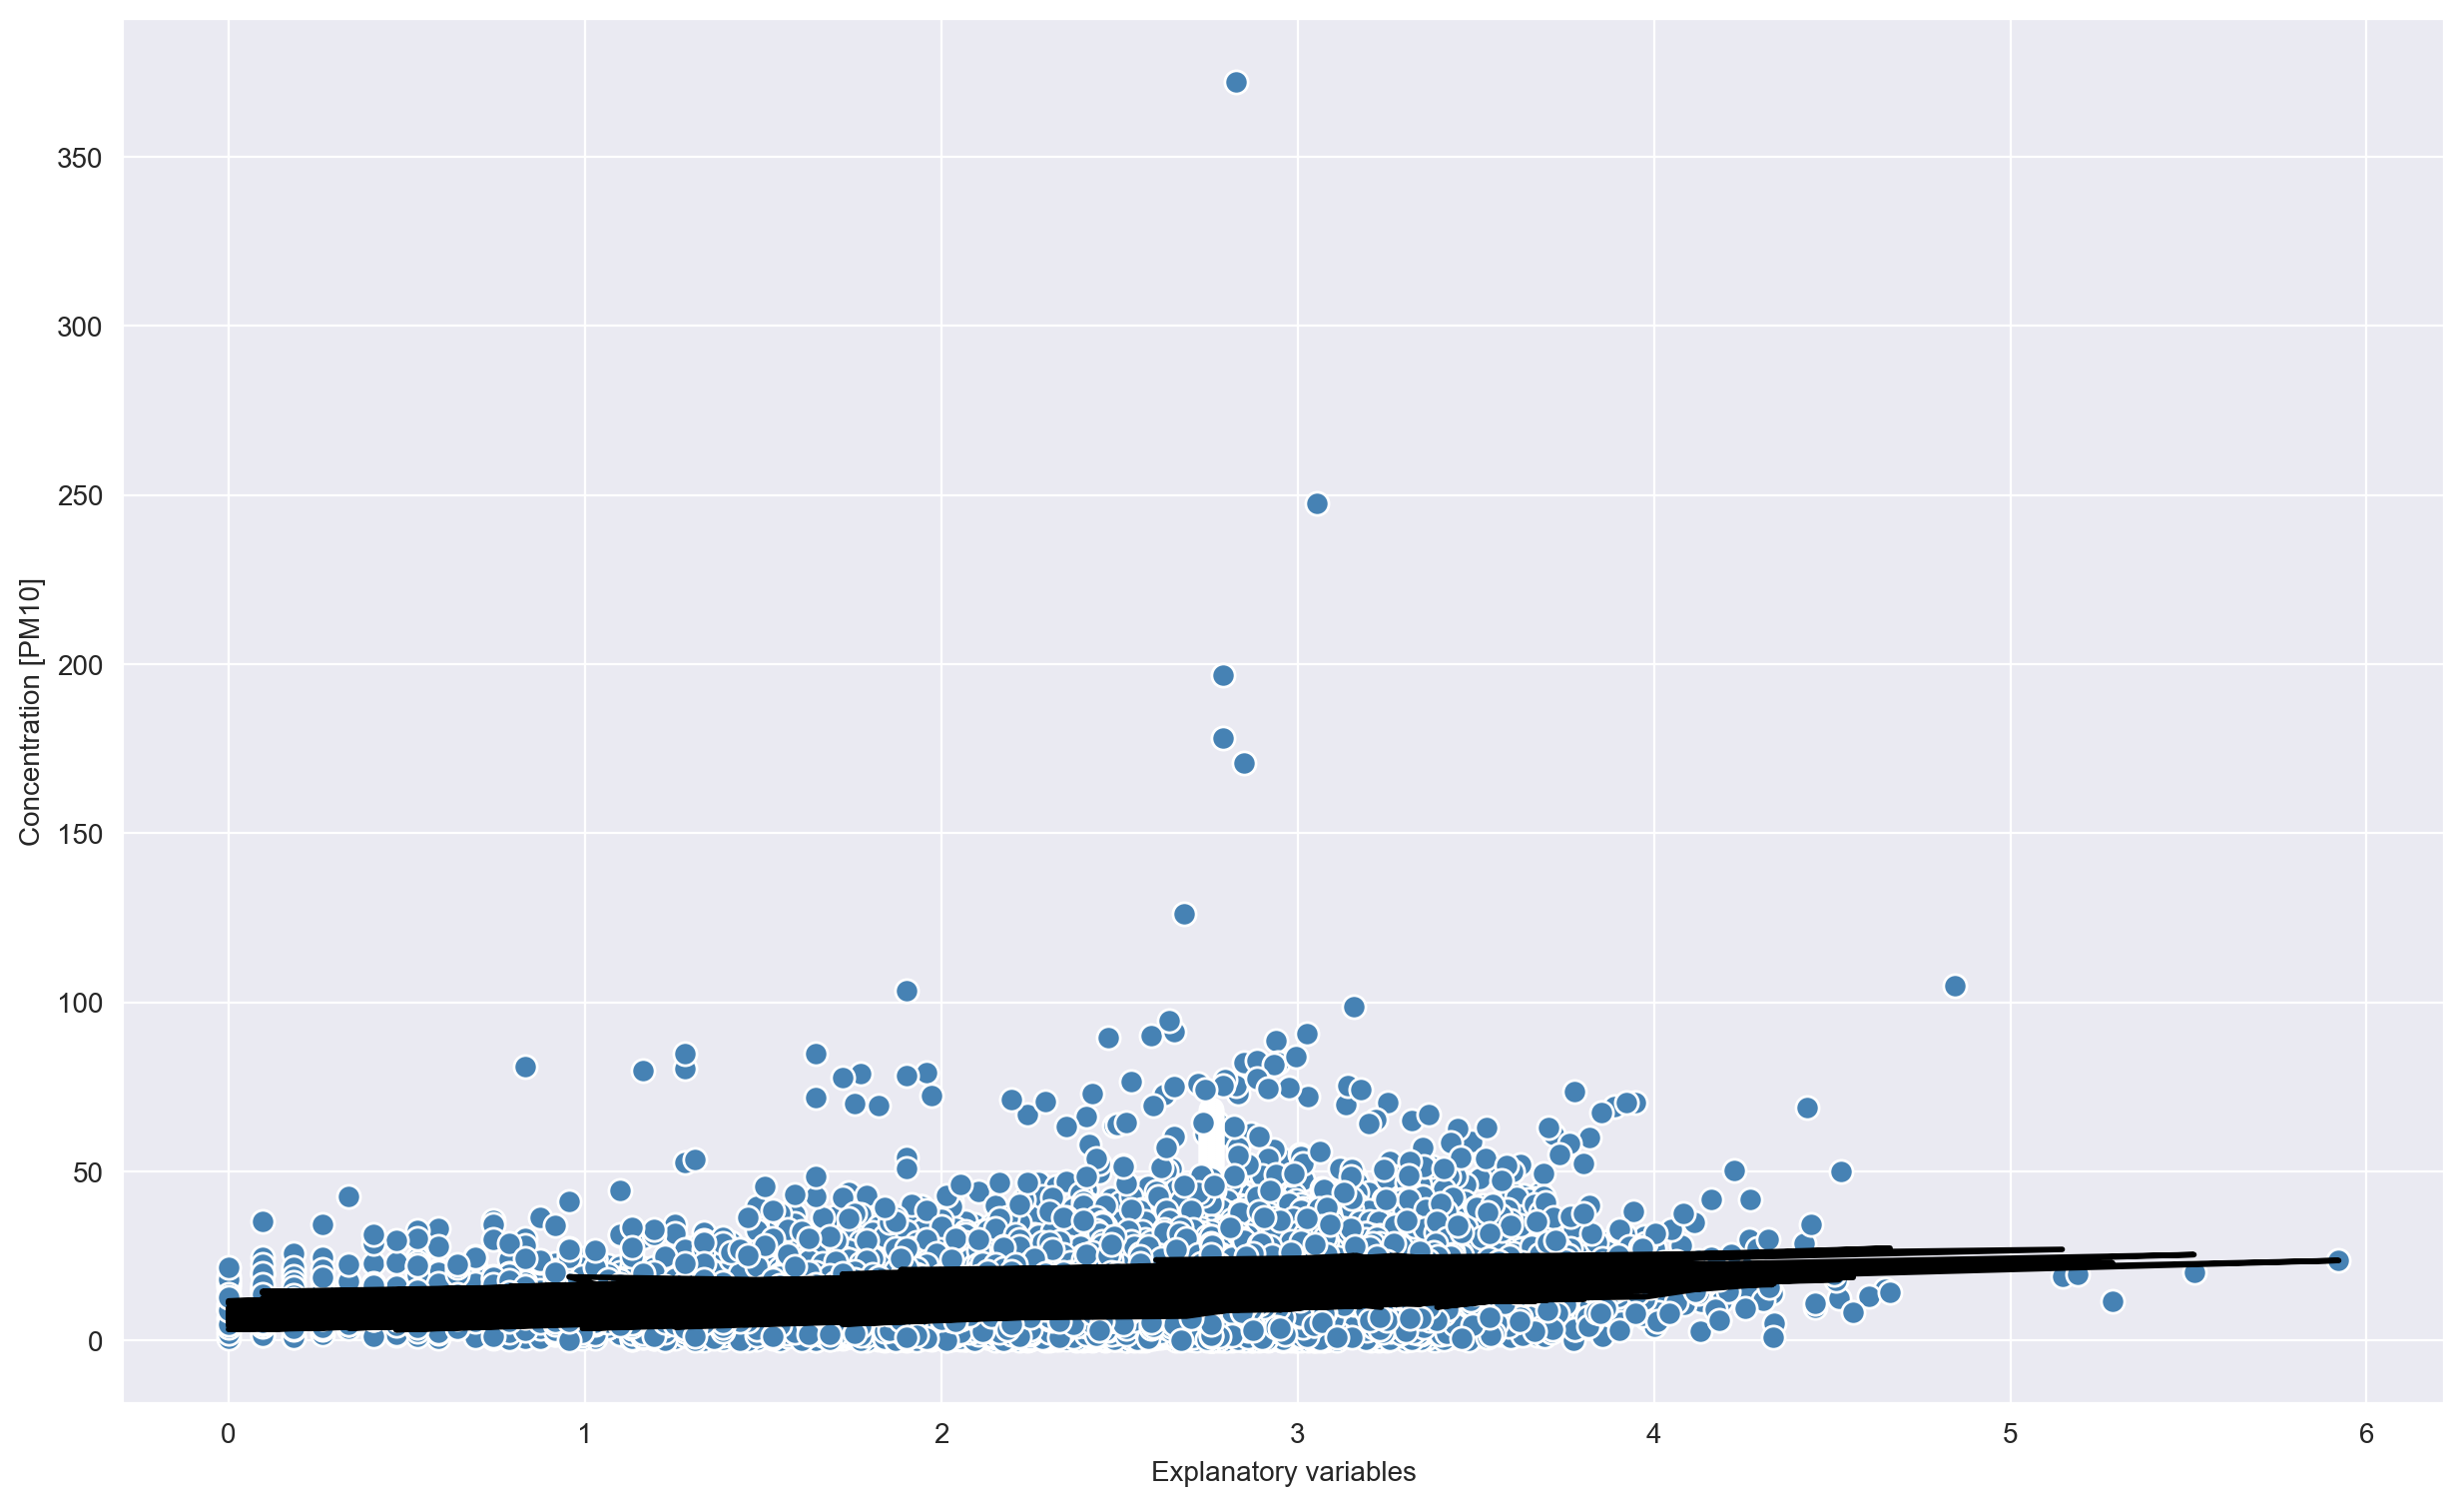

In [150]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Load the data and select the features and target variable

X = df[['Lag1', 'Lag2', 'Temp', 'Humidity', 'Wind Speed', 'Wind Dir', 'NO', 'NO2', 'SO2']]
y = df['PM10']

# Apply logarithmic transformation to the features
X_log = np.log1p(X)

# Initialize and fit the linear regression model
slr = LinearRegression()
slr.fit(X_log, y)

# Define a function to plot the regression line
def lin_reg_plot(X, y, model):
    plt.scatter(X[:, 0], y, c='steelblue', edgecolor='white', s=70)  # Plotting the first feature against y
    plt.plot(X[:, 0], model.predict(X), color='black', lw=2)  # Plotting the regression line
    plt.xlabel('Explanatory variables')
    plt.ylabel('Concentration [PM10]')
    plt.show()

# Plot the regression line
lin_reg_plot(X_log.to_numpy(), y, slr)


In [155]:

import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Add a column of ones as the constant term to the feature matrix X
X_constant = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)

# Calculate the VIF for each feature
vif = [variance_inflation_factor(X_constant, i) for i in range(X_constant.shape[1])]

# Create a DataFrame to display the VIF values
vif_data = pd.DataFrame({'Feature': ['Constant'] + list(X.columns), 'VIF': vif})
vif_data = vif_data.set_index('Feature')

# Display the VIF values
print(vif_data)


                 VIF
Feature             
Constant    0.000000
const       0.000000
Lag1        1.069622
Lag2        1.061956
Temp        1.511660
Humidity    1.398491
Wind Speed  1.424712
Wind Dir    1.134015
NO2         1.681393
SO2         1.082523


Based on these VIF values, it appears that multicollinearity is not a major issue in our model. 

Breusch-Pagan test ----
Lagrange multiplier statistic: 34.47758989564605
p-value: 7.364131362422768e-05
f-value: 4.312884181061626
f p-value: 3.3122494370553405e-05

Goldfeld-Quandt test ----
F statistic: 1.3697192743151805
p-value: 1.0447841684134865e-94
Breusch-Pagan test ----
Lagrange multiplier statistic: 34.47758989564605
p-value: 7.364131362422768e-05
f-value: 4.312884181061626
f p-value: 3.3122494370553405e-05

Goldfeld-Quandt test ----
F statistic: 1.3697192743151805
p-value: 1.0447841684134865e-94


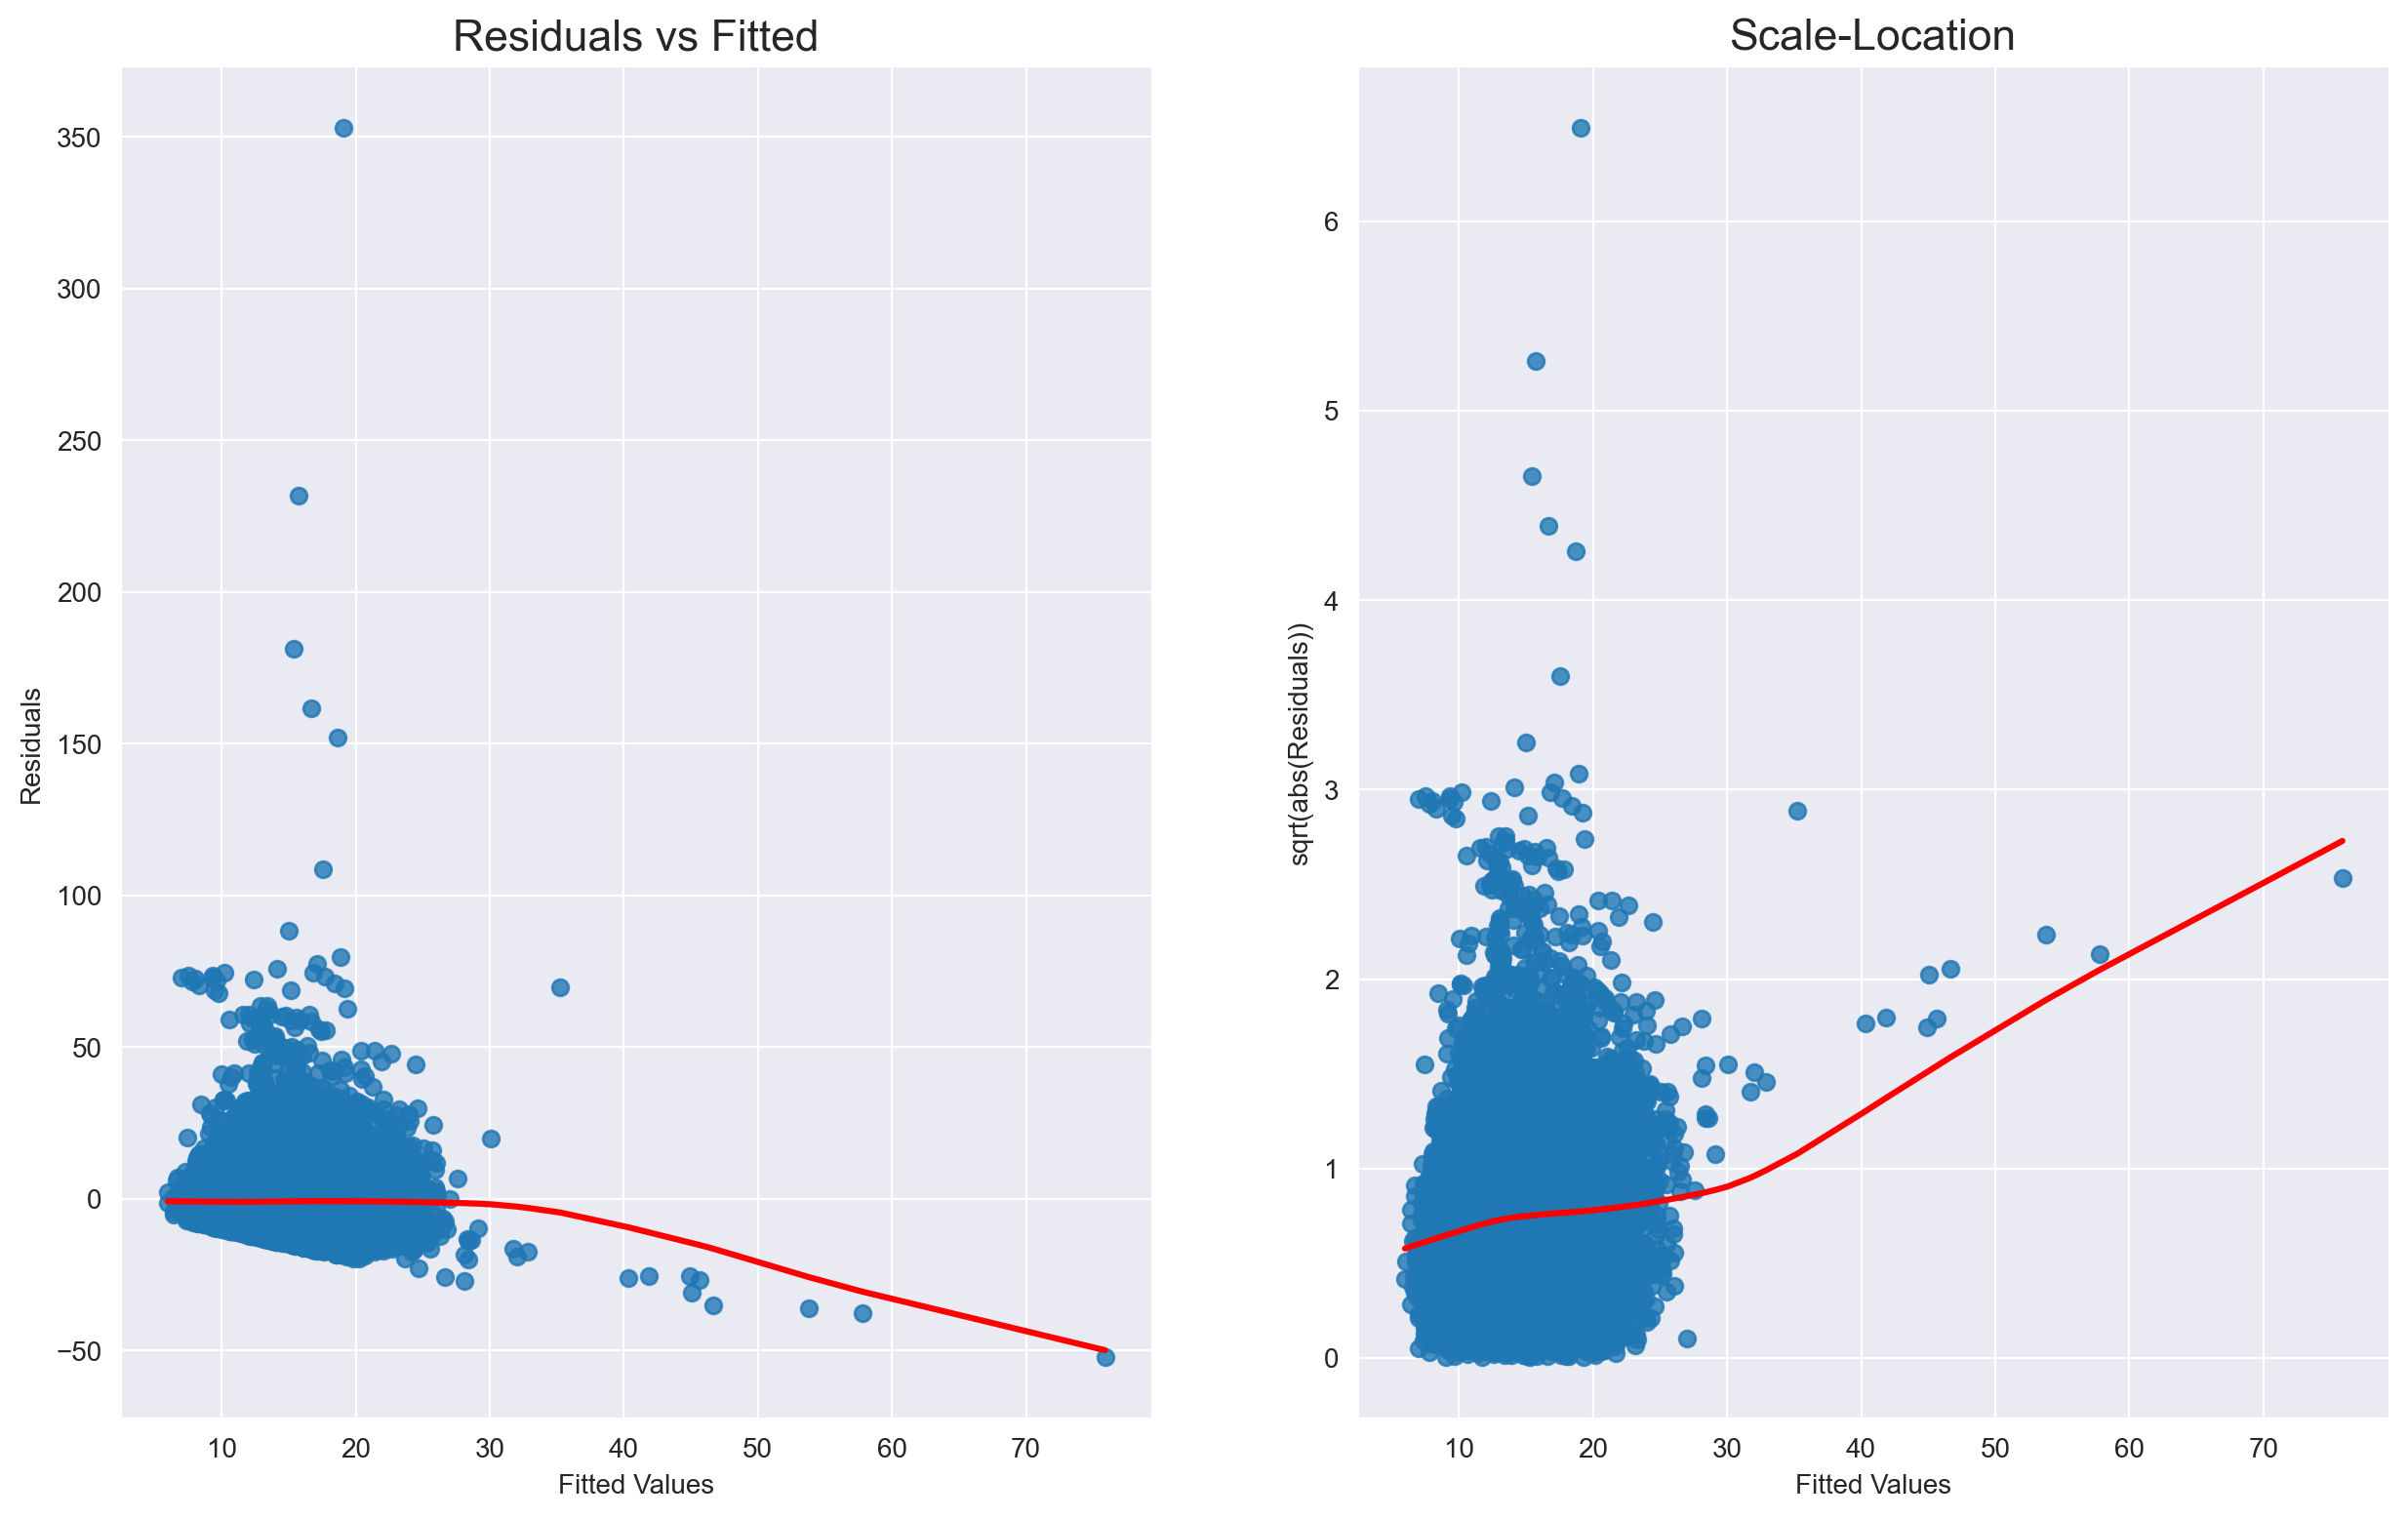

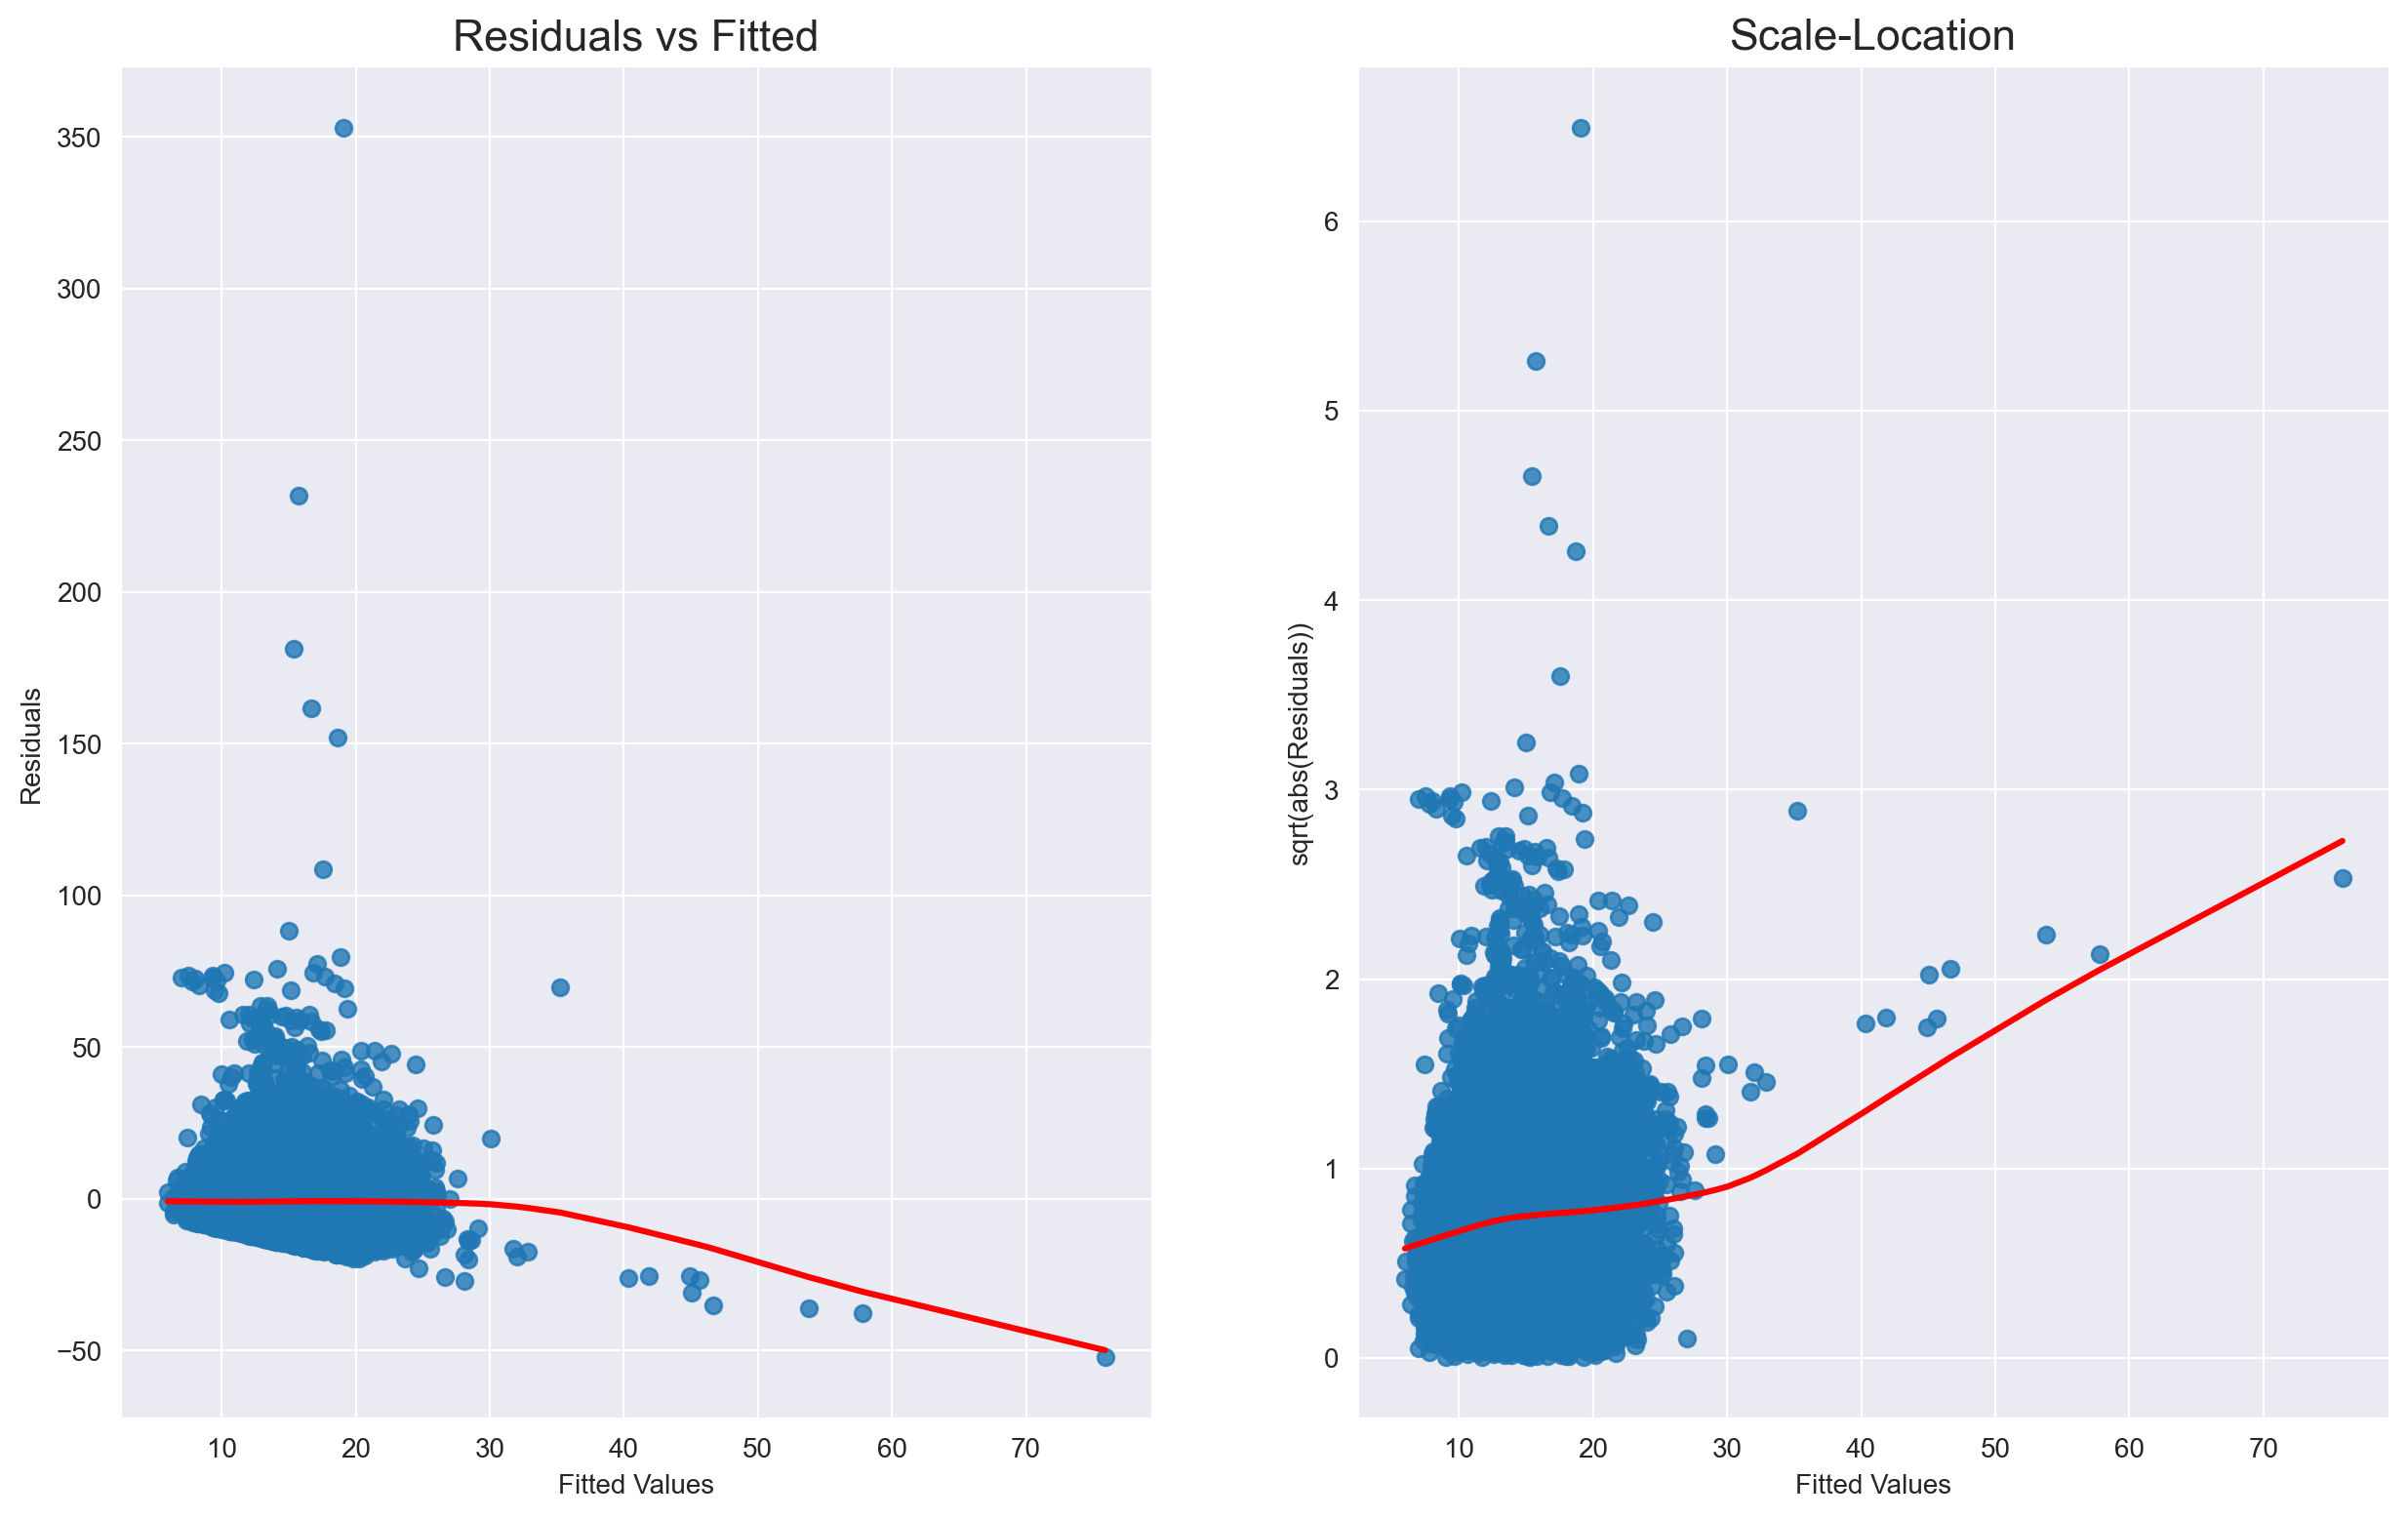

In [156]:
import seaborn as sns
import statsmodels.api as sm
from statsmodels.compat import lzip
from statsmodels.stats.diagnostic import het_breuschpagan, het_goldfeldquandt

# Fit the linear regression model
lin_reg = sm.OLS(y, X_constant).fit()

# Call the homoscedasticity_test function
homoscedasticity_test(lin_reg)


sns.set_style('darkgrid')
sns.mpl.rcParams['figure.figsize'] = (15.0, 9.0)

def homoscedasticity_test(model):
    fitted_vals = model.fittedvalues
    resids = model.resid
    resids_standardized = model.get_influence().resid_studentized_internal

    fig, ax = plt.subplots(1, 2)

    sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax[0], line_kws={'color': 'red'})
    ax[0].set_title('Residuals vs Fitted', fontsize=16)
    ax[0].set(xlabel='Fitted Values', ylabel='Residuals')

    sns.regplot(x=fitted_vals, y=np.sqrt(np.abs(resids_standardized)), lowess=True, ax=ax[1], line_kws={'color': 'red'})
    ax[1].set_title('Scale-Location', fontsize=16)
    ax[1].set(xlabel='Fitted Values', ylabel='sqrt(abs(Residuals))')

    # Perform Breusch-Pagan test
    names = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
    bp_test = lzip(names, het_breuschpagan(resids, model.model.exog))

    # Perform Goldfeld-Quandt test
    gq_test = lzip(['F statistic', 'p-value'], het_goldfeldquandt(resids, model.model.exog)[:-1])

    print('Breusch-Pagan test ----')
    for name, stat in bp_test:
        print(f'{name}: {stat}')

    print('\nGoldfeld-Quandt test ----')
    for name, stat in gq_test:
        print(f'{name}: {stat}')

# Apply the function to your linear regression model
homoscedasticity_test(lin_reg)


In [157]:
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create your time series regression model
model = sm.OLS(y_train, X_train)

# Fit the model and calculate residuals
results = model.fit()
residuals = results.resid

# Calculate the autocorrelation function (ACF)
acf_vals = acf(residuals, nlags=10)

# Find the first lag with ACF value below a threshold (e.g., 0.05)
lag_order = np.argmax(acf_vals < 0.05)

# Fit the model with Newey-West standard errors
nw_results = model.fit(cov_type='HAC', cov_kwds={'maxlags': lag_order})

# Get coefficient estimates and robust standard errors
coefs = nw_results.params
robust_se = nw_results.bse

# Print the coefficient estimates and robust standard errors
print("Coefficient Estimates:")
print(coefs)
print("\nRobust Standard Errors (Newey-West):")
print(robust_se)

# Make predictions on the test set
y_pred = results.predict(X_test)

# Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print("\nEvaluation Metrics:")
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("Correlation Coefficient (R2):", r2)


Coefficient Estimates:
const         4.721545
Lag1          0.176908
Lag2          0.047494
Temp          0.194660
Humidity     -0.038438
Wind Speed    1.351904
Wind Dir     -0.001667
NO2           0.169033
SO2           0.179443
dtype: float64

Robust Standard Errors (Newey-West):
const         0.671291
Lag1          0.011769
Lag2          0.007879
Temp          0.017845
Humidity      0.005617
Wind Speed    0.039855
Wind Dir      0.000661
NO2           0.006762
SO2           0.079480
dtype: float64

Evaluation Metrics:
Root Mean Squared Error (RMSE): 8.55727897990363
Mean Absolute Error (MAE): 5.720260270339008
Correlation Coefficient (R2): 0.11485969156612352


In [121]:
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create your time series regression model
model = sm.OLS(y_train, X_train)

# Fit the model and calculate residuals
results = model.fit()
residuals = results.resid

# Calculate the autocorrelation function (ACF)
acf_vals = acf(residuals, nlags=12)

# Find the first lag with ACF value below a threshold (e.g., 0.05)
lag_order = np.argmax(acf_vals < 0.05)

# Fit the model with Newey-West standard errors
nw_results = model.fit(cov_type='HAC', cov_kwds={'maxlags': lag_order})

# Get coefficient estimates and robust standard errors
coefs = nw_results.params
robust_se = nw_results.bse

# Print the coefficient estimates and robust standard errors
print("Coefficient Estimates:")
print(coefs)
print("\nRobust Standard Errors (Newey-West):")
print(robust_se)

# Print the regression results summary
print("\nRegression Results Summary:")
print(results.summary())

# Make predictions on the test set
y_pred = results.predict(X_test)

# Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print("\nEvaluation Metrics:")
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("Correlation Coefficient (R2):", r2)


Coefficient Estimates:
const        -0.090134
Lag1          0.438574
Lag2          0.245178
Temp          0.123954
Humidity     -0.004876
Wind Speed    0.611929
Wind Dir     -0.001444
NO2           0.097663
SO2           0.108652
dtype: float64

Robust Standard Errors (Newey-West):
const         0.562529
Lag1          0.059267
Lag2          0.038661
Temp          0.014888
Humidity      0.004386
Wind Speed    0.048581
Wind Dir      0.000527
NO2           0.006200
SO2           0.046068
dtype: float64

Regression Results Summary:
                            OLS Regression Results                            
Dep. Variable:                   PM10   R-squared:                       0.466
Model:                            OLS   Adj. R-squared:                  0.466
Method:                 Least Squares   F-statistic:                     2636.
Date:                Wed, 14 Jun 2023   Prob (F-statistic):               0.00
Time:                        17:56:06   Log-Likelihood:                

Anderson-Darling test ---- statistic: 517.0989, 5% critical value: 0.7870
Kolmogorov-Smirnov test ---- statistic: 0.4188, p-value: 0.0000


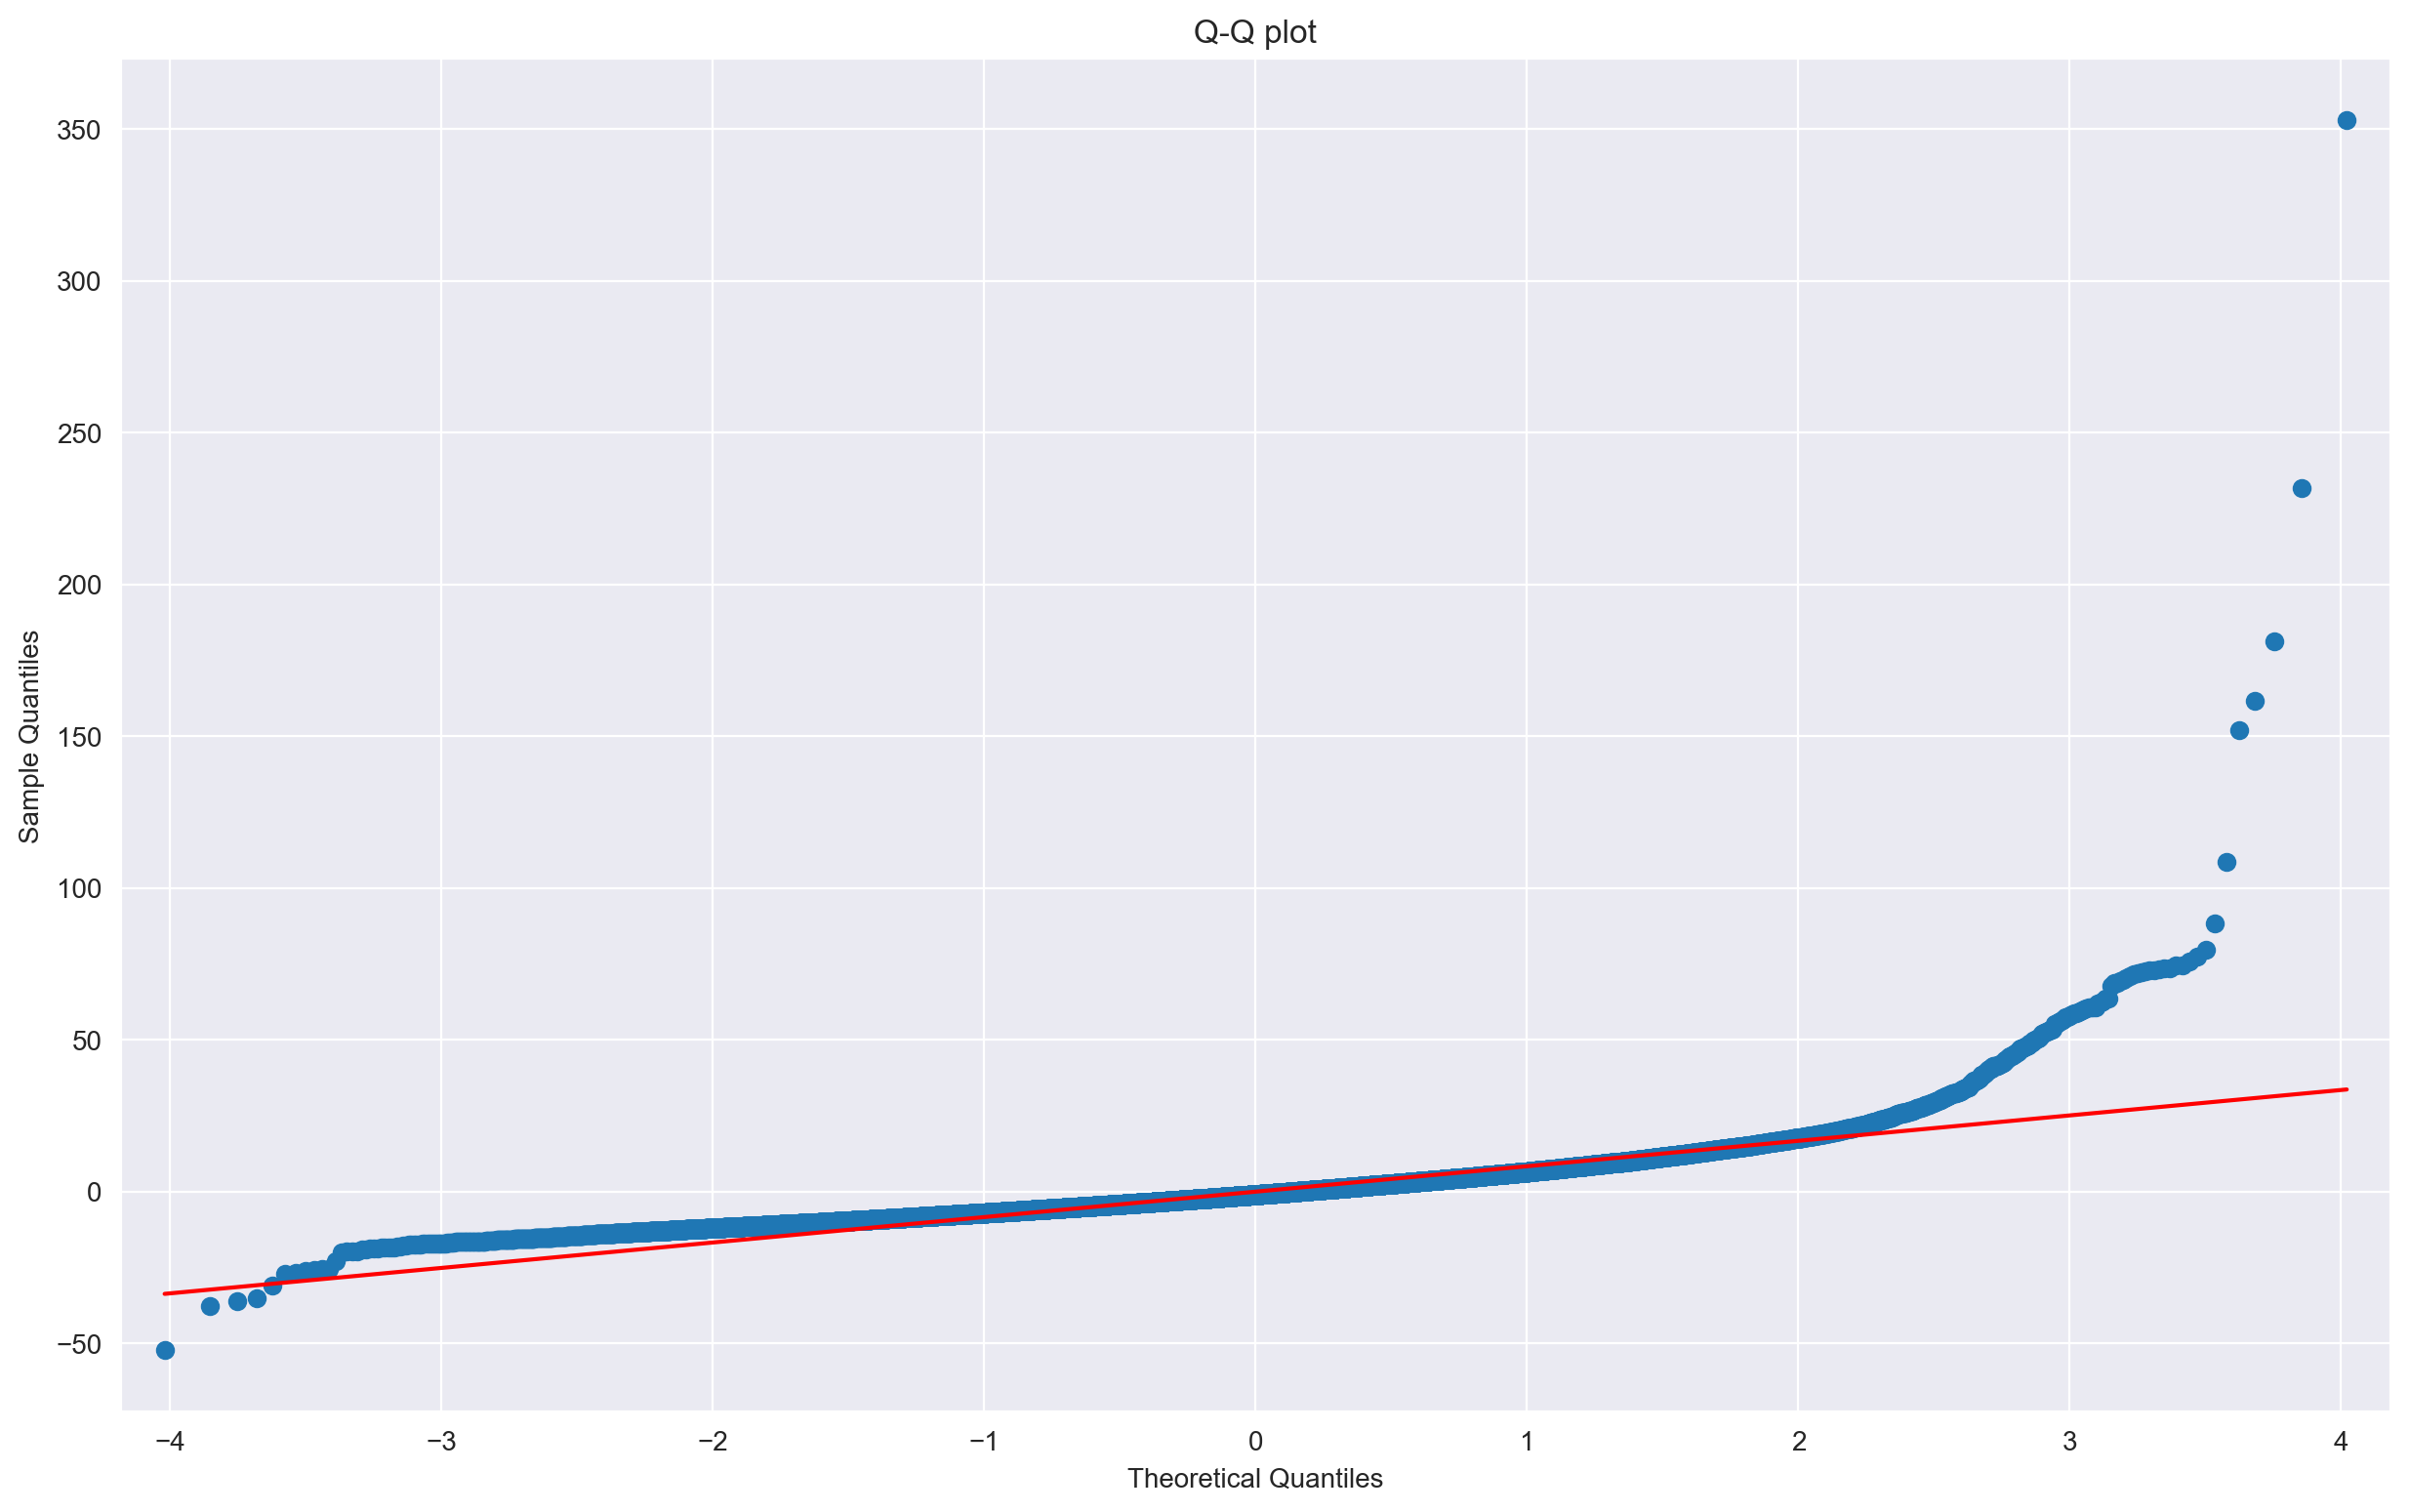

In [158]:
import statsmodels.api as sm
import scipy.stats as stats
import matplotlib.pyplot as plt

def normality_of_residuals_test(model):
    # Q-Q plot
    sm.ProbPlot(model.resid).qqplot(line='s')
    plt.title('Q-Q plot')

    # Anderson-Darling test
    ad = stats.anderson(model.resid, dist='norm')
    print(f'Anderson-Darling test ---- statistic: {ad.statistic:.4f}, 5% critical value: {ad.critical_values[2]:.4f}')

    # Kolmogorov-Smirnov test
    ks = stats.kstest(model.resid, 'norm')
    print(f'Kolmogorov-Smirnov test ---- statistic: {ks.statistic:.4f}, p-value: {ks.pvalue:.4f}')

# Perform the normality test on residuals of the OLS model (lin_reg)
normality_of_residuals_test(lin_reg)


In [128]:
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Exclude NO2 from the predictors
# X_train = X_train.drop(columns=['NO2'])
# X_test = X_test.drop(columns=['NO2'])

# Create your time series regression model
model = sm.OLS(y_train, X_train)

# Fit the model and calculate residuals
results = model.fit()
residuals = results.resid

# Calculate the autocorrelation function (ACF)
acf_vals = acf(residuals, nlags=12)

# Find the first lag with ACF value below a threshold (e.g., 0.05)
lag_order = np.argmax(acf_vals < 0.05)

# Fit the model with Newey-West standard errors
nw_results = model.fit(cov_type='HAC', cov_kwds={'maxlags': lag_order})

# Get coefficient estimates and robust standard errors
coefs = nw_results.params
robust_se = nw_results.bse

# Print the coefficient estimates and robust standard errors
print("Coefficient Estimates:")
print(coefs)
print("\nRobust Standard Errors (Newey-West):")
print(robust_se)

# Print the regression results summary
print("\nRegression Results Summary:")
print(results.summary())

# Make predictions on the test set
y_pred = results.predict(X_test)

# Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print("\nEvaluation Metrics:")
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("Correlation Coefficient (R2):", r2)


Coefficient Estimates:
const        -0.090134
Lag1          0.438574
Lag2          0.245178
Temp          0.123954
Humidity     -0.004876
Wind Speed    0.611929
Wind Dir     -0.001444
NO2           0.097663
SO2           0.108652
dtype: float64

Robust Standard Errors (Newey-West):
const         0.562529
Lag1          0.059267
Lag2          0.038661
Temp          0.014888
Humidity      0.004386
Wind Speed    0.048581
Wind Dir      0.000527
NO2           0.006200
SO2           0.046068
dtype: float64

Regression Results Summary:
                            OLS Regression Results                            
Dep. Variable:                   PM10   R-squared:                       0.466
Model:                            OLS   Adj. R-squared:                  0.466
Method:                 Least Squares   F-statistic:                     2636.
Date:                Wed, 14 Jun 2023   Prob (F-statistic):               0.00
Time:                        18:03:37   Log-Likelihood:                

VIF values below 5 are often considered acceptable, indicating a reasonably low level of multicollinearity. 
The majority of the predictor variables have VIF values below 2.5, suggesting that multicollinearity is not a severe issue in the model. However, the NO2 predictor has a VIF above 2.5, indicating a relatively higher degree of multicollinearity with the other predictors. 

In [159]:

import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Add a column of ones as the constant term to the feature matrix X
X_constant = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)

# Calculate the VIF for each feature
vif = [variance_inflation_factor(X_constant, i) for i in range(X_constant.shape[1])]

# Create a DataFrame to display the VIF values
vif_data = pd.DataFrame({'Feature': ['Constant'] + list(X.columns), 'VIF': vif})
vif_data = vif_data.set_index('Feature')

# Display the VIF values
print(vif_data)

                 VIF
Feature             
Constant    0.000000
const       0.000000
Lag1        1.069622
Lag2        1.061956
Temp        1.511660
Humidity    1.398491
Wind Speed  1.424712
Wind Dir    1.134015
NO2         1.681393
SO2         1.082523


Coefficient Estimates:
const         3.669281
Lag1          0.452695
Lag2          0.248640
Temp          0.006544
Humidity     -0.012141
Wind Speed    0.350338
Wind Dir      0.001474
SO2           0.203328
dtype: float64

Robust Standard Errors (Newey-West):
const         0.726739
Lag1          0.059864
Lag2          0.039436
Temp          0.014231
Humidity      0.005061
Wind Speed    0.044260
Wind Dir      0.000512
SO2           0.082210
dtype: float64

Regression Results Summary:
                            OLS Regression Results                            
Dep. Variable:                   PM10   R-squared:                       0.455
Model:                            OLS   Adj. R-squared:                  0.455
Method:                 Least Squares   F-statistic:                     2876.
Date:                Wed, 14 Jun 2023   Prob (F-statistic):               0.00
Time:                        18:02:07   Log-Likelihood:                -79806.
No. Observations:               24152 

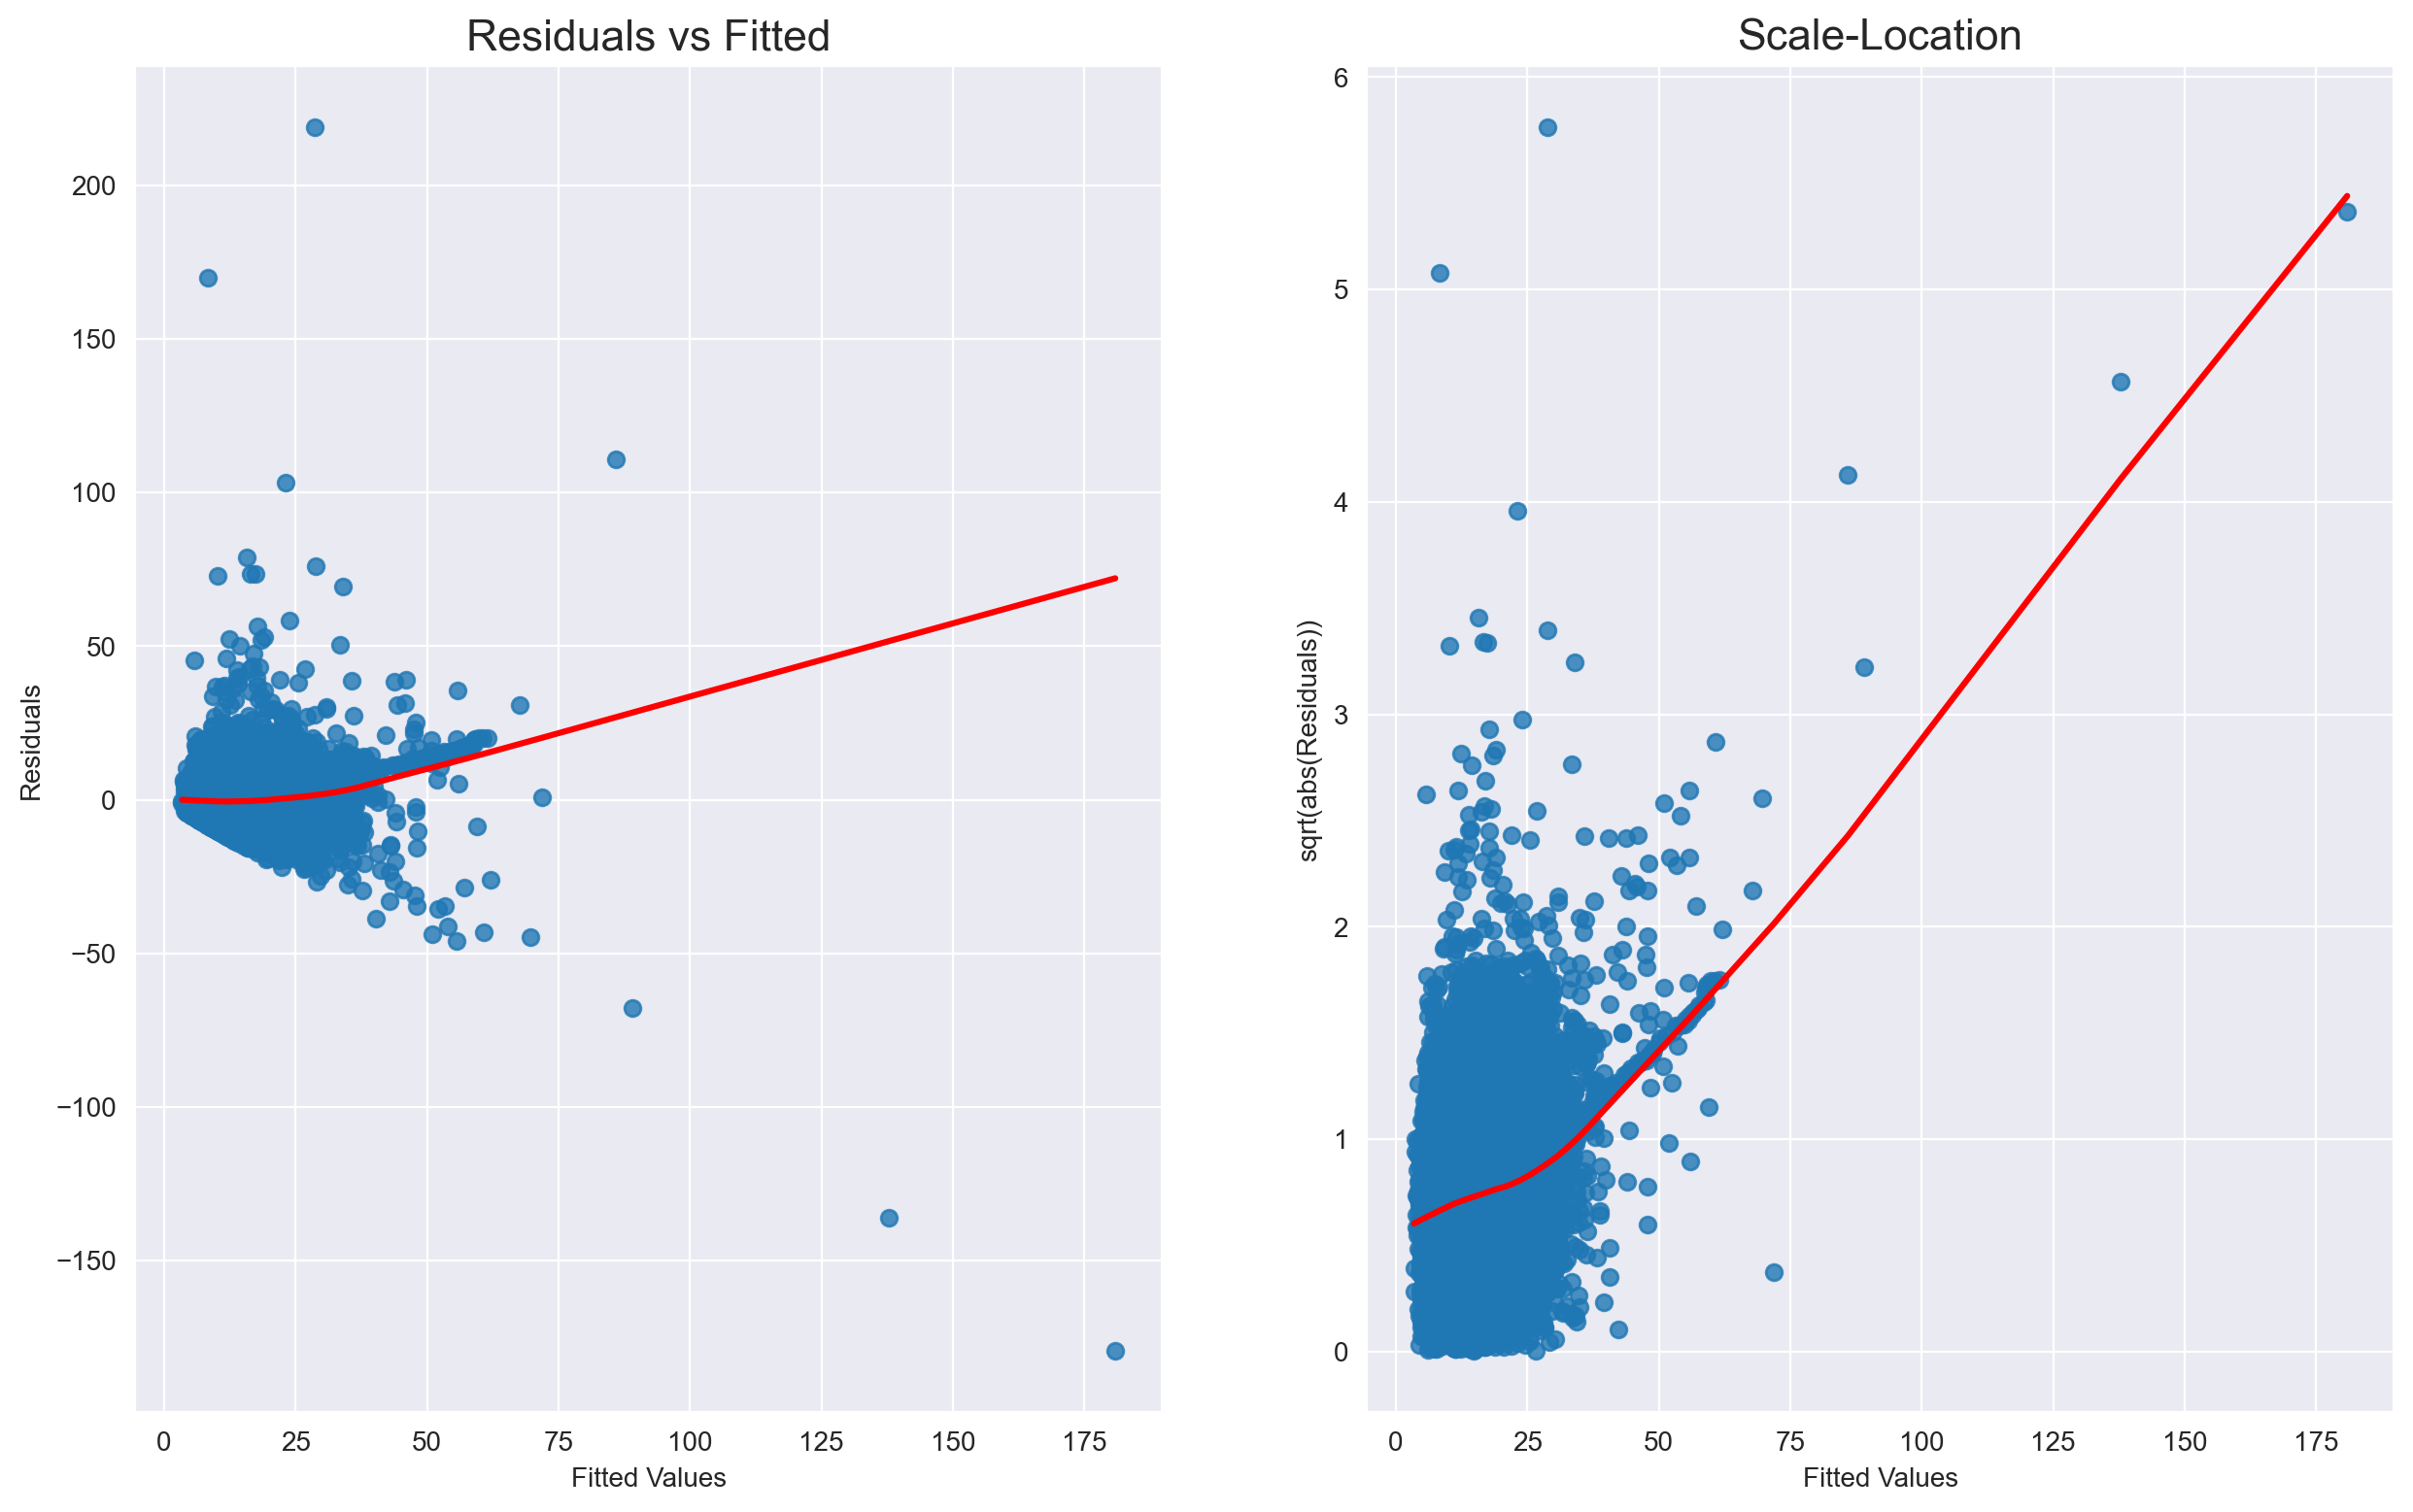

In [127]:
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Exclude NO2 from the predictors
X_train = X_train.drop(columns=['NO2'])
X_test = X_test.drop(columns=['NO2'])

# Create your time series regression model
model = sm.OLS(y_train, X_train)

# Fit the model and calculate residuals
results = model.fit()
residuals = results.resid

# Calculate the autocorrelation function (ACF)
acf_vals = acf(residuals, nlags=12)

# Find the first lag with ACF value below a threshold (e.g., 0.05)
lag_order = np.argmax(acf_vals < 0.05)

# Fit the model with Newey-West standard errors
nw_results = model.fit(cov_type='HAC', cov_kwds={'maxlags': lag_order})

# Get coefficient estimates and robust standard errors
coefs = nw_results.params
robust_se = nw_results.bse

# Print the coefficient estimates and robust standard errors
print("Coefficient Estimates:")
print(coefs)
print("\nRobust Standard Errors (Newey-West):")
print(robust_se)

# Print the regression results summary
print("\nRegression Results Summary:")
print(results.summary())

# Perform homoscedasticity test
homoscedasticity_test(results)

# Make predictions on the test set
y_pred = results.predict(X_test)

# Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print("\nEvaluation Metrics:")
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("Correlation Coefficient (R2):", r2)


In [111]:
import pandas as pd

# Assuming you have a DataFrame 'df' containing your dataset
# Replace 'df' with your actual DataFrame

# Calculate descriptive statistics
descriptive_stats = df.describe()

# Print the table of descriptive statistics
print(descriptive_stats)



              index          PM10          Lag1          Lag2         PM2.5  \
count  34504.000000  34504.000000  34504.000000  34504.000000  34504.000000   
mean   17251.500000     14.792184     14.792526     14.792868      8.239843   
std     9960.591181      8.975273      8.975049      8.974824      7.442374   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%     8625.750000      8.900000      8.900000      8.900000      4.000000   
50%    17251.500000     13.700000     13.700000     13.700000      6.500000   
75%    25877.250000     19.200000     19.200000     19.200000     10.300000   
max    34503.000000    372.000000    372.000000    372.000000    447.700000   

               Temp      Humidity    Wind Speed      Wind Dir            NO  \
count  34504.000000  34504.000000  34504.000000  34504.000000  34504.000000   
mean      16.591444     69.797380      2.823768    181.535608     10.719685   
std        3.940989     12.289822      1.593866    

In [113]:
import pandas as pd

# Assuming you have a DataFrame named 'df' containing the data
variables = ['PM10', 'PM2.5', 'Temp', 'Humidity', 'Wind Speed', 'Wind Dir', 'NO2', 'SO2']
descriptive_stats = df[variables].describe().transpose()

# Display the descriptive statistics table
print(descriptive_stats)


              count        mean        std   min   25%    50%    75%    max
PM10        34504.0   14.792184   8.975273   0.0   8.9   13.7   19.2  372.0
PM2.5       34504.0    8.239843   7.442374   0.0   4.0    6.5   10.3  447.7
Temp        34504.0   16.591444   3.940989   3.0  14.0   16.0   20.0   28.0
Humidity    34504.0   69.797380  12.289822  26.9  60.7   70.7   79.9   92.0
Wind Speed  34504.0    2.823768   1.593866   0.2   1.5    2.6    3.9    8.7
Wind Dir    34504.0  181.535608  92.468721   1.0  91.0  215.0  238.0  357.0
NO2         34504.0   14.908123  12.863990   0.0   4.7   11.3   21.9   84.3
SO2         34504.0    1.038228   2.432205   0.0   0.2    0.6    1.1  221.1


In [118]:
import pandas as pd
from tabulate import tabulate

# Assuming you have a DataFrame named 'df' containing the data
variables = ['PM10', 'PM2.5', 'Temp', 'Humidity', 'Wind Speed', 'Wind Dir', 'NO2', 'SO2']
descriptive_stats = df[variables].describe()

# Convert descriptive statistics to a formatted table
stats_table = tabulate(descriptive_stats, headers='keys', tablefmt='fancy_grid')

# Print the descriptive statistics table
print("Descriptive Statistics:")
print(stats_table)


Descriptive Statistics:
╒═══════╤═════════════╤═════════════╤═════════════╤════════════╤══════════════╤════════════╤════════════╤═════════════╕
│       │        PM10 │       PM2.5 │        Temp │   Humidity │   Wind Speed │   Wind Dir │        NO2 │         SO2 │
╞═══════╪═════════════╪═════════════╪═════════════╪════════════╪══════════════╪════════════╪════════════╪═════════════╡
│ count │ 34504       │ 34504       │ 34504       │ 34504      │  34504       │ 34504      │ 34504      │ 34504       │
├───────┼─────────────┼─────────────┼─────────────┼────────────┼──────────────┼────────────┼────────────┼─────────────┤
│ mean  │    14.7922  │     8.23984 │    16.5914  │    69.7974 │      2.82377 │   181.536  │    14.9081 │     1.03823 │
├───────┼─────────────┼─────────────┼─────────────┼────────────┼──────────────┼────────────┼────────────┼─────────────┤
│ std   │     8.97527 │     7.44237 │     3.94099 │    12.2898 │      1.59387 │    92.4687 │    12.864  │     2.43221 │
├───────┼───────

In [117]:
import pandas as pd
from tabulate import tabulate

# Assuming you have a DataFrame named 'df' containing the data
variables = ['PM10', 'PM2.5', 'Temp', 'Humidity', 'Wind Speed', 'Wind Dir', 'NO2', 'SO2']
correlation_matrix = df[variables].corr()

# Convert correlation matrix to a formatted table
correlation_table = tabulate(correlation_matrix, headers='keys', tablefmt='fancy_grid')

# Print the correlation table
print("Correlation Matrix:")
print(correlation_table)


Correlation Matrix:
╒════════════╤════════════╤═════════════╤════════════╤════════════╤══════════════╤════════════╤════════════╤════════════╕
│            │       PM10 │       PM2.5 │       Temp │   Humidity │   Wind Speed │   Wind Dir │        NO2 │        SO2 │
╞════════════╪════════════╪═════════════╪════════════╪════════════╪══════════════╪════════════╪════════════╪════════════╡
│ PM10       │  1         │  0.375045   │  0.0874894 │ -0.178522  │   0.196384   │  0.0521621 │  0.0995659 │  0.0856456 │
├────────────┼────────────┼─────────────┼────────────┼────────────┼──────────────┼────────────┼────────────┼────────────┤
│ PM2.5      │  0.375045  │  1          │  0.054058  │ -0.0573539 │  -0.00158057 │  0.0563277 │  0.136054  │  0.108886  │
├────────────┼────────────┼─────────────┼────────────┼────────────┼──────────────┼────────────┼────────────┼────────────┤
│ Temp       │  0.0874894 │  0.054058   │  1         │ -0.387548  │   0.309058   │ -0.151919  │ -0.475419  │ -0.0454815 │
├───

In [165]:
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import scipy.stats as stats

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create your time series regression model
model = sm.OLS(y_train, X_train)

# Fit the model and calculate residuals
results = model.fit()
residuals = results.resid

# # Calculate the autocorrelation function (ACF)
acf_vals = acf(residuals, nlags=12)

# # Find the first lag with ACF value below a threshold (e.g., 0.05)
lag_order = np.argmax(acf_vals < 0.05)

# Fit the model with Newey-West standard errors
nw_results = model.fit(cov_type='HAC', cov_kwds={'maxlags': lag_order})

# Get coefficient estimates and robust standard errors
coefs = nw_results.params
robust_se = nw_results.bse

# Print the coefficient estimates and robust standard errors
print("Coefficient Estimates:")
print(coefs)
print("\nRobust Standard Errors (Newey-West):")
print(robust_se)

# Print the regression results summary
print("\nRegression Results Summary:")
print(results.summary())

# Make predictions on the test set
y_pred = results.predict(X_test)

# Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print("\nEvaluation Metrics:")
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("Correlation Coefficient (R2):", r2)

# Perform normality test on the residuals
ad = stats.anderson(residuals, dist='norm')
ks = stats.kstest(residuals, 'norm')

print("\nNormality Test (Anderson-Darling):")
print("Statistic:", ad.statistic)
print("5% Critical Value:", ad.critical_values[2])

print("\nNormality Test (Kolmogorov-Smirnov):")
print("Statistic:", ks.statistic)
print("p-value:", ks.pvalue)


Coefficient Estimates:
const         4.721545
Lag1          0.176908
Lag2          0.047494
Temp          0.194660
Humidity     -0.038438
Wind Speed    1.351904
Wind Dir     -0.001667
NO2           0.169033
SO2           0.179443
dtype: float64

Robust Standard Errors (Newey-West):
const         0.671291
Lag1          0.011769
Lag2          0.007879
Temp          0.017845
Humidity      0.005617
Wind Speed    0.039855
Wind Dir      0.000661
NO2           0.006762
SO2           0.079480
dtype: float64

Regression Results Summary:
                            OLS Regression Results                            
Dep. Variable:                   PM10   R-squared:                       0.136
Model:                            OLS   Adj. R-squared:                  0.136
Method:                 Least Squares   F-statistic:                     474.4
Date:                Wed, 14 Jun 2023   Prob (F-statistic):               0.00
Time:                        18:58:12   Log-Likelihood:                

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense

# Define the input layer
inputs = Input(shape=(num_timesteps, num_features))

# Define the LSTM layer
lstm = LSTM(64)(inputs)

# Define the output layer
outputs = Dense(1)(lstm)

# Create the model
model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train, y_train, epochs=30, batch_size=4)
test_loss = model.evaluate(X_test, y_test)



we create a sequential model. We add an LSTM layer with 64 hidden units, specifying the input shape as (num_timesteps, num_features). Adjust the number of hidden units based on your specific problem. We add a Dense layer with a single output unit, which will be used for regression tasks.

In [3]:
#Compile the model
model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')

# Train the model for multiple epochs
num_epochs = 30
train_loss = []
test_loss = []

for epoch in range(num_epochs):
    # Train the model on the training data
    history = model.fit(X_train, y_train, epochs=1, batch_size=4, verbose=0)
    
    # Calculate the cost function scores for training and testing data
    train_loss.append(history.history['loss'][0])
    test_loss.append(model.evaluate(X_test, y_test, verbose=0))
    
    # Print the epoch number and cost function score
    print(f"Epoch {epoch+1}: Train Loss = {train_loss[-1]}, Test Loss = {test_loss[-1]}")

# Plot the cost function scores for each epoch
plt.plot(range(1, num_epochs+1), train_loss, label='Train Loss')
plt.plot(range(1, num_epochs+1), test_loss, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Calculate summary statistics
train_loss_mean = np.mean(train_loss)
train_loss_std = np.std(train_loss)
train_loss_min = np.min(train_loss)
train_loss_max = np.max(train_loss)

test_loss_mean = np.mean(test_loss)
test_loss_std = np.std(test_loss)
test_loss_min = np.min(test_loss)
test_loss_max = np.max(test_loss)

print("Summary Statistics:")
print(f"Train Loss - Mean: {train_loss_mean}, Std: {train_loss_std}, Min: {train_loss_min}, Max: {train_loss_max}")
print(f"Test Loss - Mean: {test_loss_mean}, Std: {test_loss_std}, Min: {test_loss_min}, Max: {test_loss_max}")


NameError: name 'model' is not defined